# Sciplex Dose

In [1]:
ood_seed = 8

In [2]:
num_ood = 1

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings

In [5]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [7]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

52

In [8]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [9]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [10]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('Nutlin', '10.0'), 657)


Removed datapoint: 657

train         11414
validation     2740
ood             657
Name: split, dtype: int64

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="condition",
    control_group="Vehicle",
    dosage_key="dose_val",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['cell_type']
)

  0%|          | 0/14811 [00:00<?, ?it/s]

 64%|██████▍   | 9533/14811 [00:00<00:00, 95324.64it/s]

100%|██████████| 14811/14811 [00:00<00:00, 95604.41it/s]

  0%|          | 0/14811 [00:00<?, ?it/s]

100%|██████████| 14811/14811 [00:00<00:00, 964504.98it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [13]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [14]:
model.train(max_epochs=400)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 179.04it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:10<1:10:23, 10.58s/it]

Epoch 1/400:   0%|          | 1/400 [00:10<1:10:23, 10.58s/it, v_num=1, recon=3.07e+3, r2_mean=0.122, adv_loss=1.48, acc_pert=0.316]

Epoch 2/400:   0%|          | 1/400 [00:10<1:10:23, 10.58s/it, v_num=1, recon=3.07e+3, r2_mean=0.122, adv_loss=1.48, acc_pert=0.316]

Epoch 2/400:   0%|          | 2/400 [00:14<42:31,  6.41s/it, v_num=1, recon=3.07e+3, r2_mean=0.122, adv_loss=1.48, acc_pert=0.316]  

Epoch 2/400:   0%|          | 2/400 [00:14<42:31,  6.41s/it, v_num=1, recon=2.34e+3, r2_mean=0.483, adv_loss=1.28, acc_pert=0.449]

Epoch 3/400:   0%|          | 2/400 [00:14<42:31,  6.41s/it, v_num=1, recon=2.34e+3, r2_mean=0.483, adv_loss=1.28, acc_pert=0.449]

Epoch 3/400:   1%|          | 3/400 [00:17<33:07,  5.01s/it, v_num=1, recon=2.34e+3, r2_mean=0.483, adv_loss=1.28, acc_pert=0.449]

Epoch 3/400:   1%|          | 3/400 [00:17<33:07,  5.01s/it, v_num=1, recon=2.19e+3, r2_mean=0.603, adv_loss=1.18, acc_pert=0.53] 

Epoch 4/400:   1%|          | 3/400 [00:17<33:07,  5.01s/it, v_num=1, recon=2.19e+3, r2_mean=0.603, adv_loss=1.18, acc_pert=0.53]

Epoch 4/400:   1%|          | 4/400 [00:20<28:28,  4.31s/it, v_num=1, recon=2.19e+3, r2_mean=0.603, adv_loss=1.18, acc_pert=0.53]

Epoch 4/400:   1%|          | 4/400 [00:20<28:28,  4.31s/it, v_num=1, recon=2.15e+3, r2_mean=0.67, adv_loss=1.09, acc_pert=0.571]

Epoch 5/400:   1%|          | 4/400 [00:20<28:28,  4.31s/it, v_num=1, recon=2.15e+3, r2_mean=0.67, adv_loss=1.09, acc_pert=0.571]

Epoch 5/400:   1%|▏         | 5/400 [00:23<26:00,  3.95s/it, v_num=1, recon=2.15e+3, r2_mean=0.67, adv_loss=1.09, acc_pert=0.571]

Epoch 5/400:   1%|▏         | 5/400 [00:23<26:00,  3.95s/it, v_num=1, recon=2.13e+3, r2_mean=0.713, adv_loss=1.03, acc_pert=0.592]

Epoch 6/400:   1%|▏         | 5/400 [00:23<26:00,  3.95s/it, v_num=1, recon=2.13e+3, r2_mean=0.713, adv_loss=1.03, acc_pert=0.592]

Epoch 6/400:   2%|▏         | 6/400 [00:27<24:41,  3.76s/it, v_num=1, recon=2.13e+3, r2_mean=0.713, adv_loss=1.03, acc_pert=0.592]

Epoch 6/400:   2%|▏         | 6/400 [00:27<24:41,  3.76s/it, v_num=1, recon=2.12e+3, r2_mean=0.743, adv_loss=0.981, acc_pert=0.615]

Epoch 7/400:   2%|▏         | 6/400 [00:27<24:41,  3.76s/it, v_num=1, recon=2.12e+3, r2_mean=0.743, adv_loss=0.981, acc_pert=0.615]

Epoch 7/400:   2%|▏         | 7/400 [00:30<23:35,  3.60s/it, v_num=1, recon=2.12e+3, r2_mean=0.743, adv_loss=0.981, acc_pert=0.615]

Epoch 7/400:   2%|▏         | 7/400 [00:30<23:35,  3.60s/it, v_num=1, recon=2.11e+3, r2_mean=0.761, adv_loss=0.943, acc_pert=0.636]

Epoch 8/400:   2%|▏         | 7/400 [00:30<23:35,  3.60s/it, v_num=1, recon=2.11e+3, r2_mean=0.761, adv_loss=0.943, acc_pert=0.636]

Epoch 8/400:   2%|▏         | 8/400 [00:33<22:52,  3.50s/it, v_num=1, recon=2.11e+3, r2_mean=0.761, adv_loss=0.943, acc_pert=0.636]

Epoch 8/400:   2%|▏         | 8/400 [00:33<22:52,  3.50s/it, v_num=1, recon=2.11e+3, r2_mean=0.782, adv_loss=0.928, acc_pert=0.645]

Epoch 9/400:   2%|▏         | 8/400 [00:33<22:52,  3.50s/it, v_num=1, recon=2.11e+3, r2_mean=0.782, adv_loss=0.928, acc_pert=0.645]

Epoch 9/400:   2%|▏         | 9/400 [00:37<22:22,  3.43s/it, v_num=1, recon=2.11e+3, r2_mean=0.782, adv_loss=0.928, acc_pert=0.645]

Epoch 9/400:   2%|▏         | 9/400 [00:37<22:22,  3.43s/it, v_num=1, recon=2.1e+3, r2_mean=0.799, adv_loss=0.914, acc_pert=0.655] 

Epoch 10/400:   2%|▏         | 9/400 [00:37<22:22,  3.43s/it, v_num=1, recon=2.1e+3, r2_mean=0.799, adv_loss=0.914, acc_pert=0.655]


disnt_basal = 0.3891816580836748

disnt_after = 0.3916623861095369

val_r2_mean = 0.8081075153567572

val_r2_var = 0.2623281121253967


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:55<52:37,  8.10s/it, v_num=1, recon=2.1e+3, r2_mean=0.799, adv_loss=0.914, acc_pert=0.655]

Epoch 10/400:   2%|▎         | 10/400 [00:55<52:37,  8.10s/it, v_num=1, recon=2.1e+3, r2_mean=0.814, adv_loss=0.894, acc_pert=0.662, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:55<52:37,  8.10s/it, v_num=1, recon=2.1e+3, r2_mean=0.814, adv_loss=0.894, acc_pert=0.662, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:59<43:00,  6.63s/it, v_num=1, recon=2.1e+3, r2_mean=0.814, adv_loss=0.894, acc_pert=0.662, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:59<43:00,  6.63s/it, v_num=1, recon=2.09e+3, r2_mean=0.826, adv_loss=0.883, acc_pert=0.662, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [00:59<43:00,  6.63s/it, v_num=1, recon=2.09e+3, r2_mean=0.826, adv_loss=0.883, acc_pert=0.662, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:02<36:13,  5.60s/it, v_num=1, recon=2.09e+3, r2_mean=0.826, adv_loss=0.883, acc_pert=0.662, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:02<36:13,  5.60s/it, v_num=1, recon=2.09e+3, r2_mean=0.836, adv_loss=0.87, acc_pert=0.673, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan] 

Epoch 13/400:   3%|▎         | 12/400 [01:02<36:13,  5.60s/it, v_num=1, recon=2.09e+3, r2_mean=0.836, adv_loss=0.87, acc_pert=0.673, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [01:05<31:37,  4.90s/it, v_num=1, recon=2.09e+3, r2_mean=0.836, adv_loss=0.87, acc_pert=0.673, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [01:05<31:37,  4.90s/it, v_num=1, recon=2.09e+3, r2_mean=0.846, adv_loss=0.857, acc_pert=0.675, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [01:05<31:37,  4.90s/it, v_num=1, recon=2.09e+3, r2_mean=0.846, adv_loss=0.857, acc_pert=0.675, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [01:08<28:24,  4.41s/it, v_num=1, recon=2.09e+3, r2_mean=0.846, adv_loss=0.857, acc_pert=0.675, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [01:08<28:24,  4.41s/it, v_num=1, recon=2.08e+3, r2_mean=0.853, adv_loss=0.853, acc_pert=0.671, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [01:08<28:24,  4.41s/it, v_num=1, recon=2.08e+3, r2_mean=0.853, adv_loss=0.853, acc_pert=0.671, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [01:12<25:58,  4.05s/it, v_num=1, recon=2.08e+3, r2_mean=0.853, adv_loss=0.853, acc_pert=0.671, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [01:12<25:58,  4.05s/it, v_num=1, recon=2.08e+3, r2_mean=0.859, adv_loss=0.845, acc_pert=0.678, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [01:12<25:58,  4.05s/it, v_num=1, recon=2.08e+3, r2_mean=0.859, adv_loss=0.845, acc_pert=0.678, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [01:15<24:15,  3.79s/it, v_num=1, recon=2.08e+3, r2_mean=0.859, adv_loss=0.845, acc_pert=0.678, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [01:15<24:15,  3.79s/it, v_num=1, recon=2.08e+3, r2_mean=0.862, adv_loss=0.838, acc_pert=0.68, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan] 

Epoch 17/400:   4%|▍         | 16/400 [01:15<24:15,  3.79s/it, v_num=1, recon=2.08e+3, r2_mean=0.862, adv_loss=0.838, acc_pert=0.68, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:18<23:08,  3.63s/it, v_num=1, recon=2.08e+3, r2_mean=0.862, adv_loss=0.838, acc_pert=0.68, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:18<23:08,  3.63s/it, v_num=1, recon=2.08e+3, r2_mean=0.868, adv_loss=0.827, acc_pert=0.685, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [01:18<23:08,  3.63s/it, v_num=1, recon=2.08e+3, r2_mean=0.868, adv_loss=0.827, acc_pert=0.685, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:21<22:15,  3.50s/it, v_num=1, recon=2.08e+3, r2_mean=0.868, adv_loss=0.827, acc_pert=0.685, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:21<22:15,  3.50s/it, v_num=1, recon=2.07e+3, r2_mean=0.873, adv_loss=0.817, acc_pert=0.686, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [01:21<22:15,  3.50s/it, v_num=1, recon=2.07e+3, r2_mean=0.873, adv_loss=0.817, acc_pert=0.686, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:24<21:40,  3.41s/it, v_num=1, recon=2.07e+3, r2_mean=0.873, adv_loss=0.817, acc_pert=0.686, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:24<21:40,  3.41s/it, v_num=1, recon=2.07e+3, r2_mean=0.875, adv_loss=0.817, acc_pert=0.683, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [01:24<21:40,  3.41s/it, v_num=1, recon=2.07e+3, r2_mean=0.875, adv_loss=0.817, acc_pert=0.683, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]


disnt_basal = 0.41445810241564723

disnt_after = 0.41702325525133477

val_r2_mean = 0.8736046959053385

val_r2_var = 0.3263943991877816


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [01:41<46:14,  7.30s/it, v_num=1, recon=2.07e+3, r2_mean=0.875, adv_loss=0.817, acc_pert=0.683, val_recon=2.1e+3, disnt_basal=0.389, disnt_after=0.392, val_r2_mean=0.808, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [01:41<46:14,  7.30s/it, v_num=1, recon=2.07e+3, r2_mean=0.877, adv_loss=0.811, acc_pert=0.689, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [01:41<46:14,  7.30s/it, v_num=1, recon=2.07e+3, r2_mean=0.877, adv_loss=0.811, acc_pert=0.689, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:44<38:31,  6.10s/it, v_num=1, recon=2.07e+3, r2_mean=0.877, adv_loss=0.811, acc_pert=0.689, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:44<38:31,  6.10s/it, v_num=1, recon=2.07e+3, r2_mean=0.879, adv_loss=0.812, acc_pert=0.688, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [01:44<38:31,  6.10s/it, v_num=1, recon=2.07e+3, r2_mean=0.879, adv_loss=0.812, acc_pert=0.688, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:47<33:02,  5.25s/it, v_num=1, recon=2.07e+3, r2_mean=0.879, adv_loss=0.812, acc_pert=0.688, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:47<33:02,  5.25s/it, v_num=1, recon=2.07e+3, r2_mean=0.88, adv_loss=0.809, acc_pert=0.691, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan] 

Epoch 23/400:   6%|▌         | 22/400 [01:47<33:02,  5.25s/it, v_num=1, recon=2.07e+3, r2_mean=0.88, adv_loss=0.809, acc_pert=0.691, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:51<29:09,  4.64s/it, v_num=1, recon=2.07e+3, r2_mean=0.88, adv_loss=0.809, acc_pert=0.691, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:51<29:09,  4.64s/it, v_num=1, recon=2.06e+3, r2_mean=0.883, adv_loss=0.8, acc_pert=0.691, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan] 

Epoch 24/400:   6%|▌         | 23/400 [01:51<29:09,  4.64s/it, v_num=1, recon=2.06e+3, r2_mean=0.883, adv_loss=0.8, acc_pert=0.691, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:54<26:28,  4.22s/it, v_num=1, recon=2.06e+3, r2_mean=0.883, adv_loss=0.8, acc_pert=0.691, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:54<26:28,  4.22s/it, v_num=1, recon=2.06e+3, r2_mean=0.882, adv_loss=0.797, acc_pert=0.695, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [01:54<26:28,  4.22s/it, v_num=1, recon=2.06e+3, r2_mean=0.882, adv_loss=0.797, acc_pert=0.695, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:57<24:15,  3.88s/it, v_num=1, recon=2.06e+3, r2_mean=0.882, adv_loss=0.797, acc_pert=0.695, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:57<24:15,  3.88s/it, v_num=1, recon=2.06e+3, r2_mean=0.883, adv_loss=0.787, acc_pert=0.697, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [01:57<24:15,  3.88s/it, v_num=1, recon=2.06e+3, r2_mean=0.883, adv_loss=0.787, acc_pert=0.697, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [02:00<22:46,  3.65s/it, v_num=1, recon=2.06e+3, r2_mean=0.883, adv_loss=0.787, acc_pert=0.697, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [02:00<22:46,  3.65s/it, v_num=1, recon=2.06e+3, r2_mean=0.885, adv_loss=0.8, acc_pert=0.694, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]  

Epoch 27/400:   6%|▋         | 26/400 [02:00<22:46,  3.65s/it, v_num=1, recon=2.06e+3, r2_mean=0.885, adv_loss=0.8, acc_pert=0.694, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [02:03<21:48,  3.51s/it, v_num=1, recon=2.06e+3, r2_mean=0.885, adv_loss=0.8, acc_pert=0.694, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [02:03<21:48,  3.51s/it, v_num=1, recon=2.05e+3, r2_mean=0.886, adv_loss=0.787, acc_pert=0.697, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [02:03<21:48,  3.51s/it, v_num=1, recon=2.05e+3, r2_mean=0.886, adv_loss=0.787, acc_pert=0.697, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [02:06<21:05,  3.40s/it, v_num=1, recon=2.05e+3, r2_mean=0.886, adv_loss=0.787, acc_pert=0.697, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [02:06<21:05,  3.40s/it, v_num=1, recon=2.05e+3, r2_mean=0.886, adv_loss=0.784, acc_pert=0.698, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [02:06<21:05,  3.40s/it, v_num=1, recon=2.05e+3, r2_mean=0.886, adv_loss=0.784, acc_pert=0.698, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [02:10<21:19,  3.45s/it, v_num=1, recon=2.05e+3, r2_mean=0.886, adv_loss=0.784, acc_pert=0.698, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [02:10<21:19,  3.45s/it, v_num=1, recon=2.05e+3, r2_mean=0.887, adv_loss=0.786, acc_pert=0.698, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [02:10<21:19,  3.45s/it, v_num=1, recon=2.05e+3, r2_mean=0.887, adv_loss=0.786, acc_pert=0.698, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]


disnt_basal = 0.4156344797354386

disnt_after = 0.417482182969037

val_r2_mean = 0.8758129873059013

val_r2_var = 0.3660740007053722


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [02:35<1:00:56,  9.88s/it, v_num=1, recon=2.05e+3, r2_mean=0.887, adv_loss=0.786, acc_pert=0.698, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.874, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [02:35<1:00:56,  9.88s/it, v_num=1, recon=2.05e+3, r2_mean=0.887, adv_loss=0.783, acc_pert=0.703, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [02:35<1:00:56,  9.88s/it, v_num=1, recon=2.05e+3, r2_mean=0.887, adv_loss=0.783, acc_pert=0.703, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [02:38<48:27,  7.88s/it, v_num=1, recon=2.05e+3, r2_mean=0.887, adv_loss=0.783, acc_pert=0.703, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]  

Epoch 31/400:   8%|▊         | 31/400 [02:38<48:27,  7.88s/it, v_num=1, recon=2.04e+3, r2_mean=0.888, adv_loss=0.776, acc_pert=0.705, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [02:38<48:27,  7.88s/it, v_num=1, recon=2.04e+3, r2_mean=0.888, adv_loss=0.776, acc_pert=0.705, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [02:41<39:43,  6.48s/it, v_num=1, recon=2.04e+3, r2_mean=0.888, adv_loss=0.776, acc_pert=0.705, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [02:41<39:43,  6.48s/it, v_num=1, recon=2.04e+3, r2_mean=0.889, adv_loss=0.765, acc_pert=0.709, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [02:41<39:43,  6.48s/it, v_num=1, recon=2.04e+3, r2_mean=0.889, adv_loss=0.765, acc_pert=0.709, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:44<33:28,  5.47s/it, v_num=1, recon=2.04e+3, r2_mean=0.889, adv_loss=0.765, acc_pert=0.709, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:44<33:28,  5.47s/it, v_num=1, recon=2.04e+3, r2_mean=0.889, adv_loss=0.772, acc_pert=0.705, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [02:44<33:28,  5.47s/it, v_num=1, recon=2.04e+3, r2_mean=0.889, adv_loss=0.772, acc_pert=0.705, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:47<29:06,  4.77s/it, v_num=1, recon=2.04e+3, r2_mean=0.889, adv_loss=0.772, acc_pert=0.705, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:47<29:06,  4.77s/it, v_num=1, recon=2.04e+3, r2_mean=0.889, adv_loss=0.764, acc_pert=0.709, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [02:47<29:06,  4.77s/it, v_num=1, recon=2.04e+3, r2_mean=0.889, adv_loss=0.764, acc_pert=0.709, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:51<26:11,  4.31s/it, v_num=1, recon=2.04e+3, r2_mean=0.889, adv_loss=0.764, acc_pert=0.709, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:51<26:11,  4.31s/it, v_num=1, recon=2.04e+3, r2_mean=0.889, adv_loss=0.769, acc_pert=0.708, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [02:51<26:11,  4.31s/it, v_num=1, recon=2.04e+3, r2_mean=0.889, adv_loss=0.769, acc_pert=0.708, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:54<23:59,  3.96s/it, v_num=1, recon=2.04e+3, r2_mean=0.889, adv_loss=0.769, acc_pert=0.708, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:54<23:59,  3.96s/it, v_num=1, recon=2.04e+3, r2_mean=0.889, adv_loss=0.769, acc_pert=0.707, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [02:54<23:59,  3.96s/it, v_num=1, recon=2.04e+3, r2_mean=0.889, adv_loss=0.769, acc_pert=0.707, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:57<22:26,  3.71s/it, v_num=1, recon=2.04e+3, r2_mean=0.889, adv_loss=0.769, acc_pert=0.707, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:57<22:26,  3.71s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.76, acc_pert=0.708, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan] 

Epoch 38/400:   9%|▉         | 37/400 [02:57<22:26,  3.71s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.76, acc_pert=0.708, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [03:00<21:21,  3.54s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.76, acc_pert=0.708, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [03:00<21:21,  3.54s/it, v_num=1, recon=2.03e+3, r2_mean=0.889, adv_loss=0.756, acc_pert=0.712, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [03:00<21:21,  3.54s/it, v_num=1, recon=2.03e+3, r2_mean=0.889, adv_loss=0.756, acc_pert=0.712, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [03:03<20:20,  3.38s/it, v_num=1, recon=2.03e+3, r2_mean=0.889, adv_loss=0.756, acc_pert=0.712, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [03:03<20:20,  3.38s/it, v_num=1, recon=2.03e+3, r2_mean=0.891, adv_loss=0.754, acc_pert=0.716, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [03:03<20:20,  3.38s/it, v_num=1, recon=2.03e+3, r2_mean=0.891, adv_loss=0.754, acc_pert=0.716, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]


disnt_basal = 0.4190883780024963

disnt_after = 0.4215200288023448

val_r2_mean = 0.8826434839855538

val_r2_var = 0.37737063982269975


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [03:26<54:35,  9.10s/it, v_num=1, recon=2.03e+3, r2_mean=0.891, adv_loss=0.754, acc_pert=0.716, val_recon=2.07e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.876, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [03:26<54:35,  9.10s/it, v_num=1, recon=2.03e+3, r2_mean=0.89, adv_loss=0.762, acc_pert=0.709, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan] 

Epoch 41/400:  10%|█         | 40/400 [03:26<54:35,  9.10s/it, v_num=1, recon=2.03e+3, r2_mean=0.89, adv_loss=0.762, acc_pert=0.709, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [03:29<43:47,  7.32s/it, v_num=1, recon=2.03e+3, r2_mean=0.89, adv_loss=0.762, acc_pert=0.709, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [03:29<43:47,  7.32s/it, v_num=1, recon=2.03e+3, r2_mean=0.891, adv_loss=0.749, acc_pert=0.717, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [03:29<43:47,  7.32s/it, v_num=1, recon=2.03e+3, r2_mean=0.891, adv_loss=0.749, acc_pert=0.717, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [03:32<36:16,  6.08s/it, v_num=1, recon=2.03e+3, r2_mean=0.891, adv_loss=0.749, acc_pert=0.717, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [03:32<36:16,  6.08s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.759, acc_pert=0.714, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [03:32<36:16,  6.08s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.759, acc_pert=0.714, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [03:35<30:53,  5.19s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.759, acc_pert=0.714, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [03:35<30:53,  5.19s/it, v_num=1, recon=2.03e+3, r2_mean=0.891, adv_loss=0.748, acc_pert=0.715, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [03:35<30:53,  5.19s/it, v_num=1, recon=2.03e+3, r2_mean=0.891, adv_loss=0.748, acc_pert=0.715, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [03:38<27:08,  4.58s/it, v_num=1, recon=2.03e+3, r2_mean=0.891, adv_loss=0.748, acc_pert=0.715, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [03:38<27:08,  4.58s/it, v_num=1, recon=2.02e+3, r2_mean=0.892, adv_loss=0.749, acc_pert=0.717, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [03:38<27:08,  4.58s/it, v_num=1, recon=2.02e+3, r2_mean=0.892, adv_loss=0.749, acc_pert=0.717, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [03:41<24:36,  4.16s/it, v_num=1, recon=2.02e+3, r2_mean=0.892, adv_loss=0.749, acc_pert=0.717, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [03:41<24:36,  4.16s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.753, acc_pert=0.718, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [03:41<24:36,  4.16s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.753, acc_pert=0.718, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [03:45<22:54,  3.88s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.753, acc_pert=0.718, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [03:45<22:54,  3.88s/it, v_num=1, recon=2.02e+3, r2_mean=0.893, adv_loss=0.747, acc_pert=0.715, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [03:45<22:54,  3.88s/it, v_num=1, recon=2.02e+3, r2_mean=0.893, adv_loss=0.747, acc_pert=0.715, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [03:48<21:31,  3.66s/it, v_num=1, recon=2.02e+3, r2_mean=0.893, adv_loss=0.747, acc_pert=0.715, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [03:48<21:31,  3.66s/it, v_num=1, recon=2.02e+3, r2_mean=0.893, adv_loss=0.745, acc_pert=0.718, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [03:48<21:31,  3.66s/it, v_num=1, recon=2.02e+3, r2_mean=0.893, adv_loss=0.745, acc_pert=0.718, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [03:51<20:35,  3.51s/it, v_num=1, recon=2.02e+3, r2_mean=0.893, adv_loss=0.745, acc_pert=0.718, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [03:51<20:35,  3.51s/it, v_num=1, recon=2.02e+3, r2_mean=0.892, adv_loss=0.741, acc_pert=0.715, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [03:51<20:35,  3.51s/it, v_num=1, recon=2.02e+3, r2_mean=0.892, adv_loss=0.741, acc_pert=0.715, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [03:54<19:53,  3.40s/it, v_num=1, recon=2.02e+3, r2_mean=0.892, adv_loss=0.741, acc_pert=0.715, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [03:54<19:53,  3.40s/it, v_num=1, recon=2.02e+3, r2_mean=0.892, adv_loss=0.738, acc_pert=0.719, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [03:54<19:53,  3.40s/it, v_num=1, recon=2.02e+3, r2_mean=0.892, adv_loss=0.738, acc_pert=0.719, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]


disnt_basal = 0.4237502191608416

disnt_after = 0.4260716204036146

val_r2_mean = 0.8882553013888272

val_r2_var = 0.3835449934005737


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [04:15<51:05,  8.76s/it, v_num=1, recon=2.02e+3, r2_mean=0.892, adv_loss=0.738, acc_pert=0.719, val_recon=2.05e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [04:15<51:05,  8.76s/it, v_num=1, recon=2.02e+3, r2_mean=0.894, adv_loss=0.734, acc_pert=0.721, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [04:15<51:05,  8.76s/it, v_num=1, recon=2.02e+3, r2_mean=0.894, adv_loss=0.734, acc_pert=0.721, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [04:18<40:57,  7.04s/it, v_num=1, recon=2.02e+3, r2_mean=0.894, adv_loss=0.734, acc_pert=0.721, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [04:18<40:57,  7.04s/it, v_num=1, recon=2.02e+3, r2_mean=0.894, adv_loss=0.741, acc_pert=0.715, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [04:18<40:57,  7.04s/it, v_num=1, recon=2.02e+3, r2_mean=0.894, adv_loss=0.741, acc_pert=0.715, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [04:22<34:11,  5.89s/it, v_num=1, recon=2.02e+3, r2_mean=0.894, adv_loss=0.741, acc_pert=0.715, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [04:22<34:11,  5.89s/it, v_num=1, recon=2.01e+3, r2_mean=0.893, adv_loss=0.738, acc_pert=0.717, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [04:22<34:11,  5.89s/it, v_num=1, recon=2.01e+3, r2_mean=0.893, adv_loss=0.738, acc_pert=0.717, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [04:25<29:26,  5.09s/it, v_num=1, recon=2.01e+3, r2_mean=0.893, adv_loss=0.738, acc_pert=0.717, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [04:25<29:26,  5.09s/it, v_num=1, recon=2.01e+3, r2_mean=0.894, adv_loss=0.729, acc_pert=0.719, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [04:25<29:26,  5.09s/it, v_num=1, recon=2.01e+3, r2_mean=0.894, adv_loss=0.729, acc_pert=0.719, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [04:28<26:05,  4.53s/it, v_num=1, recon=2.01e+3, r2_mean=0.894, adv_loss=0.729, acc_pert=0.719, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [04:28<26:05,  4.53s/it, v_num=1, recon=2.01e+3, r2_mean=0.893, adv_loss=0.725, acc_pert=0.724, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [04:28<26:05,  4.53s/it, v_num=1, recon=2.01e+3, r2_mean=0.893, adv_loss=0.725, acc_pert=0.724, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [04:31<23:50,  4.15s/it, v_num=1, recon=2.01e+3, r2_mean=0.893, adv_loss=0.725, acc_pert=0.724, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [04:31<23:50,  4.15s/it, v_num=1, recon=2.01e+3, r2_mean=0.894, adv_loss=0.734, acc_pert=0.724, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [04:31<23:50,  4.15s/it, v_num=1, recon=2.01e+3, r2_mean=0.894, adv_loss=0.734, acc_pert=0.724, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [04:35<22:14,  3.88s/it, v_num=1, recon=2.01e+3, r2_mean=0.894, adv_loss=0.734, acc_pert=0.724, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [04:35<22:14,  3.88s/it, v_num=1, recon=2.01e+3, r2_mean=0.894, adv_loss=0.724, acc_pert=0.727, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [04:35<22:14,  3.88s/it, v_num=1, recon=2.01e+3, r2_mean=0.894, adv_loss=0.724, acc_pert=0.727, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [04:38<21:06,  3.69s/it, v_num=1, recon=2.01e+3, r2_mean=0.894, adv_loss=0.724, acc_pert=0.727, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [04:38<21:06,  3.69s/it, v_num=1, recon=2.01e+3, r2_mean=0.894, adv_loss=0.723, acc_pert=0.727, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [04:38<21:06,  3.69s/it, v_num=1, recon=2.01e+3, r2_mean=0.894, adv_loss=0.723, acc_pert=0.727, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [04:41<20:09,  3.54s/it, v_num=1, recon=2.01e+3, r2_mean=0.894, adv_loss=0.723, acc_pert=0.727, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [04:41<20:09,  3.54s/it, v_num=1, recon=2e+3, r2_mean=0.894, adv_loss=0.726, acc_pert=0.722, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]   

Epoch 59/400:  14%|█▍        | 58/400 [04:41<20:09,  3.54s/it, v_num=1, recon=2e+3, r2_mean=0.894, adv_loss=0.726, acc_pert=0.722, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [04:44<19:36,  3.45s/it, v_num=1, recon=2e+3, r2_mean=0.894, adv_loss=0.726, acc_pert=0.722, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [04:44<19:36,  3.45s/it, v_num=1, recon=2.01e+3, r2_mean=0.894, adv_loss=0.728, acc_pert=0.721, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [04:44<19:36,  3.45s/it, v_num=1, recon=2.01e+3, r2_mean=0.894, adv_loss=0.728, acc_pert=0.721, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]


disnt_basal = 0.41813273783386395

disnt_after = 0.4212710875998646

val_r2_mean = 0.8888315666805616

val_r2_var = 0.3989346785978837


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [05:00<39:54,  7.04s/it, v_num=1, recon=2.01e+3, r2_mean=0.894, adv_loss=0.728, acc_pert=0.721, val_recon=2.04e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [05:00<39:54,  7.04s/it, v_num=1, recon=2.01e+3, r2_mean=0.895, adv_loss=0.728, acc_pert=0.721, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [05:00<39:54,  7.04s/it, v_num=1, recon=2.01e+3, r2_mean=0.895, adv_loss=0.728, acc_pert=0.721, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [05:03<33:42,  5.97s/it, v_num=1, recon=2.01e+3, r2_mean=0.895, adv_loss=0.728, acc_pert=0.721, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [05:03<33:42,  5.97s/it, v_num=1, recon=2e+3, r2_mean=0.894, adv_loss=0.735, acc_pert=0.716, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]   

Epoch 62/400:  15%|█▌        | 61/400 [05:03<33:42,  5.97s/it, v_num=1, recon=2e+3, r2_mean=0.894, adv_loss=0.735, acc_pert=0.716, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [05:06<29:14,  5.19s/it, v_num=1, recon=2e+3, r2_mean=0.894, adv_loss=0.735, acc_pert=0.716, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [05:06<29:14,  5.19s/it, v_num=1, recon=2e+3, r2_mean=0.895, adv_loss=0.725, acc_pert=0.725, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [05:06<29:14,  5.19s/it, v_num=1, recon=2e+3, r2_mean=0.895, adv_loss=0.725, acc_pert=0.725, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [05:10<26:38,  4.74s/it, v_num=1, recon=2e+3, r2_mean=0.895, adv_loss=0.725, acc_pert=0.725, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [05:10<26:38,  4.74s/it, v_num=1, recon=2e+3, r2_mean=0.895, adv_loss=0.729, acc_pert=0.725, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [05:10<26:38,  4.74s/it, v_num=1, recon=2e+3, r2_mean=0.895, adv_loss=0.729, acc_pert=0.725, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [05:14<24:17,  4.34s/it, v_num=1, recon=2e+3, r2_mean=0.895, adv_loss=0.729, acc_pert=0.725, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [05:14<24:17,  4.34s/it, v_num=1, recon=2e+3, r2_mean=0.894, adv_loss=0.718, acc_pert=0.734, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [05:14<24:17,  4.34s/it, v_num=1, recon=2e+3, r2_mean=0.894, adv_loss=0.718, acc_pert=0.734, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [05:17<22:42,  4.07s/it, v_num=1, recon=2e+3, r2_mean=0.894, adv_loss=0.718, acc_pert=0.734, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [05:17<22:42,  4.07s/it, v_num=1, recon=2e+3, r2_mean=0.895, adv_loss=0.714, acc_pert=0.731, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [05:17<22:42,  4.07s/it, v_num=1, recon=2e+3, r2_mean=0.895, adv_loss=0.714, acc_pert=0.731, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [05:20<21:28,  3.86s/it, v_num=1, recon=2e+3, r2_mean=0.895, adv_loss=0.714, acc_pert=0.731, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [05:20<21:28,  3.86s/it, v_num=1, recon=2e+3, r2_mean=0.896, adv_loss=0.721, acc_pert=0.729, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [05:20<21:28,  3.86s/it, v_num=1, recon=2e+3, r2_mean=0.896, adv_loss=0.721, acc_pert=0.729, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [05:24<20:36,  3.71s/it, v_num=1, recon=2e+3, r2_mean=0.896, adv_loss=0.721, acc_pert=0.729, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [05:24<20:36,  3.71s/it, v_num=1, recon=2e+3, r2_mean=0.896, adv_loss=0.725, acc_pert=0.724, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [05:24<20:36,  3.71s/it, v_num=1, recon=2e+3, r2_mean=0.896, adv_loss=0.725, acc_pert=0.724, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [05:27<19:55,  3.60s/it, v_num=1, recon=2e+3, r2_mean=0.896, adv_loss=0.725, acc_pert=0.724, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [05:27<19:55,  3.60s/it, v_num=1, recon=2e+3, r2_mean=0.896, adv_loss=0.721, acc_pert=0.732, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [05:27<19:55,  3.60s/it, v_num=1, recon=2e+3, r2_mean=0.896, adv_loss=0.721, acc_pert=0.732, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [05:30<19:14,  3.49s/it, v_num=1, recon=2e+3, r2_mean=0.896, adv_loss=0.721, acc_pert=0.732, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [05:30<19:14,  3.49s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.716, acc_pert=0.729, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [05:30<19:14,  3.49s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.716, acc_pert=0.729, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]


disnt_basal = 0.4201365255670177

disnt_after = 0.42203436252254106

val_r2_mean = 0.8901349349455401

val_r2_var = 0.40057582042434


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [05:48<42:21,  7.70s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.716, acc_pert=0.729, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [05:48<42:21,  7.70s/it, v_num=1, recon=1.99e+3, r2_mean=0.896, adv_loss=0.719, acc_pert=0.731, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]  

Epoch 71/400:  18%|█▊        | 70/400 [05:48<42:21,  7.70s/it, v_num=1, recon=1.99e+3, r2_mean=0.896, adv_loss=0.719, acc_pert=0.731, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [05:51<34:56,  6.37s/it, v_num=1, recon=1.99e+3, r2_mean=0.896, adv_loss=0.719, acc_pert=0.731, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [05:51<34:56,  6.37s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.721, acc_pert=0.73, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]    

Epoch 72/400:  18%|█▊        | 71/400 [05:51<34:56,  6.37s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.721, acc_pert=0.73, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [05:55<30:33,  5.59s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.721, acc_pert=0.73, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [05:55<30:33,  5.59s/it, v_num=1, recon=1.99e+3, r2_mean=0.896, adv_loss=0.709, acc_pert=0.726, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [05:55<30:33,  5.59s/it, v_num=1, recon=1.99e+3, r2_mean=0.896, adv_loss=0.709, acc_pert=0.726, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [05:58<26:38,  4.89s/it, v_num=1, recon=1.99e+3, r2_mean=0.896, adv_loss=0.709, acc_pert=0.726, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [05:58<26:38,  4.89s/it, v_num=1, recon=1.99e+3, r2_mean=0.897, adv_loss=0.709, acc_pert=0.729, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [05:58<26:38,  4.89s/it, v_num=1, recon=1.99e+3, r2_mean=0.897, adv_loss=0.709, acc_pert=0.729, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [06:01<23:49,  4.38s/it, v_num=1, recon=1.99e+3, r2_mean=0.897, adv_loss=0.709, acc_pert=0.729, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [06:01<23:49,  4.38s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.711, acc_pert=0.729, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [06:01<23:49,  4.38s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.711, acc_pert=0.729, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [06:05<21:53,  4.04s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.711, acc_pert=0.729, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [06:05<21:53,  4.04s/it, v_num=1, recon=1.99e+3, r2_mean=0.897, adv_loss=0.715, acc_pert=0.725, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [06:05<21:53,  4.04s/it, v_num=1, recon=1.99e+3, r2_mean=0.897, adv_loss=0.715, acc_pert=0.725, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [06:08<20:27,  3.79s/it, v_num=1, recon=1.99e+3, r2_mean=0.897, adv_loss=0.715, acc_pert=0.725, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [06:08<20:27,  3.79s/it, v_num=1, recon=1.99e+3, r2_mean=0.896, adv_loss=0.709, acc_pert=0.734, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [06:08<20:27,  3.79s/it, v_num=1, recon=1.99e+3, r2_mean=0.896, adv_loss=0.709, acc_pert=0.734, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [06:11<19:33,  3.63s/it, v_num=1, recon=1.99e+3, r2_mean=0.896, adv_loss=0.709, acc_pert=0.734, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [06:11<19:33,  3.63s/it, v_num=1, recon=1.99e+3, r2_mean=0.897, adv_loss=0.706, acc_pert=0.733, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [06:11<19:33,  3.63s/it, v_num=1, recon=1.99e+3, r2_mean=0.897, adv_loss=0.706, acc_pert=0.733, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [06:14<18:50,  3.51s/it, v_num=1, recon=1.99e+3, r2_mean=0.897, adv_loss=0.706, acc_pert=0.733, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [06:14<18:50,  3.51s/it, v_num=1, recon=1.99e+3, r2_mean=0.897, adv_loss=0.704, acc_pert=0.736, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [06:14<18:50,  3.51s/it, v_num=1, recon=1.99e+3, r2_mean=0.897, adv_loss=0.704, acc_pert=0.736, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [06:18<19:52,  3.72s/it, v_num=1, recon=1.99e+3, r2_mean=0.897, adv_loss=0.704, acc_pert=0.736, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [06:18<19:52,  3.72s/it, v_num=1, recon=1.98e+3, r2_mean=0.896, adv_loss=0.709, acc_pert=0.725, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [06:18<19:52,  3.72s/it, v_num=1, recon=1.98e+3, r2_mean=0.896, adv_loss=0.709, acc_pert=0.725, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]


disnt_basal = 0.4173373091027331

disnt_after = 0.41951097647551594

val_r2_mean = 0.8948061785914679

val_r2_var = 0.4078692176125267


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [06:39<46:00,  8.63s/it, v_num=1, recon=1.98e+3, r2_mean=0.896, adv_loss=0.709, acc_pert=0.725, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.89, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [06:39<46:00,  8.63s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.711, acc_pert=0.725, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [06:39<46:00,  8.63s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.711, acc_pert=0.725, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [06:43<39:28,  7.43s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.711, acc_pert=0.725, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [06:43<39:28,  7.43s/it, v_num=1, recon=1.98e+3, r2_mean=0.896, adv_loss=0.704, acc_pert=0.732, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [06:43<39:28,  7.43s/it, v_num=1, recon=1.98e+3, r2_mean=0.896, adv_loss=0.704, acc_pert=0.732, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [06:46<32:25,  6.12s/it, v_num=1, recon=1.98e+3, r2_mean=0.896, adv_loss=0.704, acc_pert=0.732, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [06:46<32:25,  6.12s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.702, acc_pert=0.733, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [06:46<32:25,  6.12s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.702, acc_pert=0.733, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [06:49<27:42,  5.25s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.702, acc_pert=0.733, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [06:49<27:42,  5.25s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.704, acc_pert=0.728, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [06:49<27:42,  5.25s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.704, acc_pert=0.728, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [06:53<24:34,  4.67s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.704, acc_pert=0.728, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [06:53<24:34,  4.67s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.701, acc_pert=0.734, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [06:53<24:34,  4.67s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.701, acc_pert=0.734, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [06:56<22:14,  4.24s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.701, acc_pert=0.734, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [06:56<22:14,  4.24s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.7, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]  

Epoch 86/400:  21%|██▏       | 85/400 [06:56<22:14,  4.24s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.7, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [06:59<20:37,  3.94s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.7, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [06:59<20:37,  3.94s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.705, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [06:59<20:37,  3.94s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.705, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [07:02<19:27,  3.73s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.705, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [07:02<19:27,  3.73s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.7, acc_pert=0.731, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]  

Epoch 88/400:  22%|██▏       | 87/400 [07:02<19:27,  3.73s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.7, acc_pert=0.731, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [07:06<18:34,  3.57s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.7, acc_pert=0.731, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [07:06<18:34,  3.57s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.704, acc_pert=0.729, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [07:06<18:34,  3.57s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.704, acc_pert=0.729, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [07:09<17:55,  3.46s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.704, acc_pert=0.729, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [07:09<17:55,  3.46s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.698, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [07:09<17:55,  3.46s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.698, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.4134408012858726

disnt_after = 0.41533895829256356

val_r2_mean = 0.8901398230682719

val_r2_var = 0.4065637415105646

Epoch 90/400:  22%|██▎       | 90/400 [07:30<45:08,  8.74s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.698, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [07:30<45:08,  8.74s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.698, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [07:30<45:08,  8.74s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.698, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [07:33<36:28,  7.08s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.698, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [07:33<36:28,  7.08s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.687, acc_pert=0.732, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [07:33<36:28,  7.08s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.687, acc_pert=0.732, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [07:37<31:17,  6.10s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.687, acc_pert=0.732, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [07:37<31:17,  6.10s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.698, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [07:37<31:17,  6.10s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.698, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [07:40<26:49,  5.24s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.698, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [07:40<26:49,  5.24s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.695, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [07:40<26:49,  5.24s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.695, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [07:43<23:44,  4.65s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.695, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [07:43<23:44,  4.65s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.695, acc_pert=0.74, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan] 

Epoch 95/400:  24%|██▎       | 94/400 [07:43<23:44,  4.65s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.695, acc_pert=0.74, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [07:47<21:32,  4.24s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.695, acc_pert=0.74, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [07:47<21:32,  4.24s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.693, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [07:47<21:32,  4.24s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.693, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [07:50<19:59,  3.95s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.693, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [07:50<19:59,  3.95s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.702, acc_pert=0.732, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [07:50<19:59,  3.95s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.702, acc_pert=0.732, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [07:53<18:52,  3.74s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.702, acc_pert=0.732, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [07:53<18:52,  3.74s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.694, acc_pert=0.736, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [07:53<18:52,  3.74s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.694, acc_pert=0.736, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [07:57<18:04,  3.59s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.694, acc_pert=0.736, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [07:57<18:04,  3.59s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.695, acc_pert=0.731, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [07:57<18:04,  3.59s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.695, acc_pert=0.731, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [08:00<17:27,  3.48s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.695, acc_pert=0.731, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [08:00<17:27,  3.48s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.694, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [08:00<17:27,  3.48s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.694, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]


disnt_basal = 0.4174681562066347

disnt_after = 0.41949120965392167

val_r2_mean = 0.8913006836717777

val_r2_var = 0.419060845266689


Epoch 00099: cpa_metric reached. Module best state updated.


Epoch 100/400:  25%|██▌       | 100/400 [08:27<52:32, 10.51s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.694, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [08:27<52:32, 10.51s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.69, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [08:27<52:32, 10.51s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.69, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [08:30<41:27,  8.32s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.69, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [08:30<41:27,  8.32s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.692, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [08:30<41:27,  8.32s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.692, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [08:33<33:41,  6.78s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.692, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [08:33<33:41,  6.78s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.692, acc_pert=0.736, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [08:33<33:41,  6.78s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.692, acc_pert=0.736, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [08:36<28:27,  5.75s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.692, acc_pert=0.736, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [08:36<28:27,  5.75s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.693, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [08:36<28:27,  5.75s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.693, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [08:40<24:36,  4.99s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.693, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [08:40<24:36,  4.99s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.692, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [08:40<24:36,  4.99s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.692, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [08:43<21:48,  4.44s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.692, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [08:43<21:48,  4.44s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.687, acc_pert=0.741, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [08:43<21:48,  4.44s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.687, acc_pert=0.741, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [08:46<19:58,  4.08s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.687, acc_pert=0.741, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [08:46<19:58,  4.08s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.692, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [08:46<19:58,  4.08s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.692, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [08:49<18:41,  3.83s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.692, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [08:49<18:41,  3.83s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.689, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [08:49<18:41,  3.83s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.689, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [08:52<17:45,  3.65s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.689, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [08:52<17:45,  3.65s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.689, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [08:52<17:45,  3.65s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.689, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [08:56<16:57,  3.50s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.689, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [08:56<16:57,  3.50s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.689, acc_pert=0.734, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]  

Epoch 110/400:  27%|██▋       | 109/400 [08:56<16:57,  3.50s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.689, acc_pert=0.734, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]


disnt_basal = 0.4158168621524117

disnt_after = 0.41777900141026497

val_r2_mean = 0.8944474084810777

val_r2_var = 0.4251479696143756


Epoch 00109: cpa_metric reached. Module best state updated.


Epoch 110/400:  28%|██▊       | 110/400 [09:12<35:22,  7.32s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.689, acc_pert=0.734, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [09:12<35:22,  7.32s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.685, acc_pert=0.741, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [09:12<35:22,  7.32s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.685, acc_pert=0.741, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [09:15<29:38,  6.15s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.685, acc_pert=0.741, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [09:15<29:38,  6.15s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.683, acc_pert=0.735, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [09:15<29:38,  6.15s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.683, acc_pert=0.735, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [09:19<25:37,  5.34s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.683, acc_pert=0.735, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [09:19<25:37,  5.34s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.689, acc_pert=0.737, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [09:19<25:37,  5.34s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.689, acc_pert=0.737, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [09:22<22:51,  4.78s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.689, acc_pert=0.737, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [09:22<22:51,  4.78s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.692, acc_pert=0.737, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]  

Epoch 114/400:  28%|██▊       | 113/400 [09:22<22:51,  4.78s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.692, acc_pert=0.737, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [09:25<20:39,  4.34s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.692, acc_pert=0.737, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [09:25<20:39,  4.34s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.684, acc_pert=0.737, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [09:25<20:39,  4.34s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.684, acc_pert=0.737, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [09:29<19:06,  4.02s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.684, acc_pert=0.737, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [09:29<19:06,  4.02s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.681, acc_pert=0.741, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [09:29<19:06,  4.02s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.681, acc_pert=0.741, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [09:32<17:59,  3.80s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.681, acc_pert=0.741, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [09:32<17:59,  3.80s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.679, acc_pert=0.737, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [09:32<17:59,  3.80s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.679, acc_pert=0.737, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [09:35<17:13,  3.65s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.679, acc_pert=0.737, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [09:35<17:13,  3.65s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.681, acc_pert=0.738, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [09:35<17:13,  3.65s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.681, acc_pert=0.738, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [09:39<16:39,  3.54s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.681, acc_pert=0.738, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [09:39<16:39,  3.54s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.69, acc_pert=0.735, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan] 

Epoch 119/400:  30%|██▉       | 118/400 [09:39<16:39,  3.54s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.69, acc_pert=0.735, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [09:42<16:10,  3.45s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.69, acc_pert=0.735, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [09:42<16:10,  3.45s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.685, acc_pert=0.735, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [09:42<16:10,  3.45s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.685, acc_pert=0.735, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.416596983956641

disnt_after = 0.4187416344216582

val_r2_mean = 0.8874083551493559

val_r2_var = 0.4267971542748538

Epoch 120/400:  30%|███       | 120/400 [09:55<30:17,  6.49s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.685, acc_pert=0.735, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [09:55<30:17,  6.49s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.687, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [09:55<30:17,  6.49s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.687, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [09:59<25:45,  5.54s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.687, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [09:59<25:45,  5.54s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.673, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]  

Epoch 122/400:  30%|███       | 121/400 [09:59<25:45,  5.54s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.673, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [10:02<22:35,  4.87s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.673, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [10:02<22:35,  4.87s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.68, acc_pert=0.741, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan] 

Epoch 123/400:  30%|███       | 122/400 [10:02<22:35,  4.87s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.68, acc_pert=0.741, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [10:05<20:21,  4.41s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.68, acc_pert=0.741, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [10:05<20:21,  4.41s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.672, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [10:05<20:21,  4.41s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.672, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [10:09<18:54,  4.11s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.672, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [10:09<18:54,  4.11s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.674, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [10:09<18:54,  4.11s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.674, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [10:12<18:07,  3.96s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.674, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [10:12<18:07,  3.96s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.684, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]  

Epoch 126/400:  31%|███▏      | 125/400 [10:12<18:07,  3.96s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.684, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [10:16<17:00,  3.73s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.684, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [10:16<17:00,  3.73s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.685, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [10:16<17:00,  3.73s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.685, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [10:19<16:12,  3.56s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.685, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [10:19<16:12,  3.56s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.683, acc_pert=0.74, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan] 

Epoch 128/400:  32%|███▏      | 127/400 [10:19<16:12,  3.56s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.683, acc_pert=0.74, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [10:22<15:55,  3.51s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.683, acc_pert=0.74, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [10:22<15:55,  3.51s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.675, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [10:22<15:55,  3.51s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.675, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [10:25<15:19,  3.39s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.675, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [10:25<15:19,  3.39s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.681, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [10:25<15:19,  3.39s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.681, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]


disnt_basal = 0.4196032684791271

disnt_after = 0.42213471510067185

val_r2_mean = 0.8924711888486687

val_r2_var = 0.43881682970307095


Epoch 00129: cpa_metric reached. Module best state updated.


Epoch 130/400:  32%|███▎      | 130/400 [10:50<44:13,  9.83s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.681, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.887, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [10:50<44:13,  9.83s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.684, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan] 

Epoch 131/400:  32%|███▎      | 130/400 [10:50<44:13,  9.83s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.684, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [10:54<35:19,  7.88s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.684, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [10:54<35:19,  7.88s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.672, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [10:54<35:19,  7.88s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.672, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [10:57<28:55,  6.48s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.672, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [10:57<28:55,  6.48s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.678, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]  

Epoch 133/400:  33%|███▎      | 132/400 [10:57<28:55,  6.48s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.678, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [11:00<24:52,  5.59s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.678, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [11:00<24:52,  5.59s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.676, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [11:00<24:52,  5.59s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.676, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [11:04<21:43,  4.90s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.676, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [11:04<21:43,  4.90s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.675, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]  

Epoch 135/400:  34%|███▎      | 134/400 [11:04<21:43,  4.90s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.675, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [11:09<22:58,  5.20s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.675, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [11:09<22:58,  5.20s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.685, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [11:09<22:58,  5.20s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.685, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [11:13<20:17,  4.61s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.685, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [11:13<20:17,  4.61s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.674, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [11:13<20:17,  4.61s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.674, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [11:16<18:23,  4.20s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.674, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [11:16<18:23,  4.20s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.669, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [11:16<18:23,  4.20s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.669, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [11:19<16:59,  3.89s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.669, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [11:19<16:59,  3.89s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.687, acc_pert=0.74, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan] 

Epoch 139/400:  34%|███▍      | 138/400 [11:19<16:59,  3.89s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.687, acc_pert=0.74, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [11:22<16:04,  3.70s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.687, acc_pert=0.74, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [11:22<16:04,  3.70s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.675, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan] 

Epoch 140/400:  35%|███▍      | 139/400 [11:22<16:04,  3.70s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.675, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]


disnt_basal = 0.415259805975746

disnt_after = 0.4179943787701088

val_r2_mean = 0.8892504421147431

val_r2_var = 0.4279311001300811

Epoch 140/400:  35%|███▌      | 140/400 [11:41<35:05,  8.10s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.675, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [11:41<35:05,  8.10s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.671, acc_pert=0.741, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [11:41<35:05,  8.10s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.671, acc_pert=0.741, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [11:44<28:45,  6.66s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.671, acc_pert=0.741, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [11:44<28:45,  6.66s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.674, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [11:44<28:45,  6.66s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.674, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [11:47<24:09,  5.62s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.674, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [11:47<24:09,  5.62s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.676, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [11:47<24:09,  5.62s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.676, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [11:50<21:04,  4.92s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.676, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [11:50<21:04,  4.92s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.674, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [11:50<21:04,  4.92s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.674, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [11:54<18:51,  4.42s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.674, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [11:54<18:51,  4.42s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.675, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [11:54<18:51,  4.42s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.675, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [11:57<17:16,  4.07s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.675, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [11:57<17:16,  4.07s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.673, acc_pert=0.741, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [11:57<17:16,  4.07s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.673, acc_pert=0.741, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [12:00<16:09,  3.82s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.673, acc_pert=0.741, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [12:00<16:09,  3.82s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [12:00<16:09,  3.82s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [12:03<15:21,  3.64s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [12:03<15:21,  3.64s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan] 

Epoch 148/400:  37%|███▋      | 147/400 [12:03<15:21,  3.64s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [12:07<14:50,  3.53s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [12:07<14:50,  3.53s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.671, acc_pert=0.74, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [12:07<14:50,  3.53s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.671, acc_pert=0.74, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [12:10<14:24,  3.44s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.671, acc_pert=0.74, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [12:10<14:24,  3.44s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.672, acc_pert=0.741, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [12:10<14:24,  3.44s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.672, acc_pert=0.741, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]


disnt_basal = 0.41393914036072005

disnt_after = 0.4166446400543675

val_r2_mean = 0.8870615476911717

val_r2_var = 0.4328431113199755

Epoch 150/400:  38%|███▊      | 150/400 [12:36<43:09, 10.36s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.672, acc_pert=0.741, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [12:36<43:09, 10.36s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [12:36<43:09, 10.36s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [12:40<34:11,  8.24s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [12:40<34:11,  8.24s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [12:40<34:11,  8.24s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [12:43<27:55,  6.76s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [12:43<27:55,  6.76s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.674, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [12:43<27:55,  6.76s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.674, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [12:46<23:31,  5.72s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.674, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [12:46<23:31,  5.72s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.667, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [12:46<23:31,  5.72s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.667, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [12:50<20:32,  5.01s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.667, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [12:50<20:32,  5.01s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan] 

Epoch 155/400:  38%|███▊      | 154/400 [12:50<20:32,  5.01s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [12:53<18:52,  4.62s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [12:53<18:52,  4.62s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.666, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [12:53<18:52,  4.62s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.666, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [12:57<17:11,  4.23s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.666, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [12:57<17:11,  4.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.665, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [12:57<17:11,  4.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.665, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [13:00<15:55,  3.93s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.665, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [13:00<15:55,  3.93s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan] 

Epoch 158/400:  39%|███▉      | 157/400 [13:00<15:55,  3.93s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [13:03<15:01,  3.72s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [13:03<15:01,  3.72s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [13:03<15:01,  3.72s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [13:06<14:24,  3.59s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [13:06<14:24,  3.59s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.669, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [13:06<14:24,  3.59s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.669, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]


disnt_basal = 0.4077697968456024

disnt_after = 0.4101978657434229

val_r2_mean = 0.892466306144541

val_r2_var = 0.42605039043859994

Epoch 160/400:  40%|████      | 160/400 [13:25<32:49,  8.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.669, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [13:25<32:49,  8.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.677, acc_pert=0.74, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]  

Epoch 161/400:  40%|████      | 160/400 [13:25<32:49,  8.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.677, acc_pert=0.74, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [13:29<26:58,  6.77s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.677, acc_pert=0.74, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [13:29<26:58,  6.77s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [13:29<26:58,  6.77s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [13:32<22:48,  5.75s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [13:32<22:48,  5.75s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.66, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [13:32<22:48,  5.75s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.66, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [13:36<19:58,  5.06s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.66, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [13:36<19:58,  5.06s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [13:36<19:58,  5.06s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [13:39<17:57,  4.56s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [13:39<17:57,  4.56s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.666, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [13:39<17:57,  4.56s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.666, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [13:42<16:22,  4.18s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.666, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [13:42<16:22,  4.18s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan] 

Epoch 166/400:  41%|████▏     | 165/400 [13:42<16:22,  4.18s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [13:46<15:14,  3.91s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [13:46<15:14,  3.91s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.665, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [13:46<15:14,  3.91s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.665, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [13:49<14:23,  3.71s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.665, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [13:49<14:23,  3.71s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.666, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [13:49<14:23,  3.71s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.666, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [13:52<13:50,  3.58s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.666, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [13:52<13:50,  3.58s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.668, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [13:52<13:50,  3.58s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.668, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [13:55<13:26,  3.49s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.668, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [13:55<13:26,  3.49s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.664, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [13:55<13:26,  3.49s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.664, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]


disnt_basal = 0.40534535501991853

disnt_after = 0.4076571786915862

val_r2_mean = 0.8953394754366443

val_r2_var = 0.4358116724274375


Epoch 00169: cpa_metric reached. Module best state updated.


Epoch 170/400:  42%|████▎     | 170/400 [14:18<35:50,  9.35s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.664, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.892, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [14:18<35:50,  9.35s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [14:18<35:50,  9.35s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [14:22<28:40,  7.51s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [14:22<28:40,  7.51s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.665, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [14:22<28:40,  7.51s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.665, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [14:25<23:40,  6.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.665, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [14:25<23:40,  6.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.669, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [14:25<23:40,  6.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.669, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [14:28<20:11,  5.34s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.669, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [14:28<20:11,  5.34s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.74, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]  

Epoch 174/400:  43%|████▎     | 173/400 [14:28<20:11,  5.34s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.74, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [14:31<17:43,  4.71s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.74, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [14:31<17:43,  4.71s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.657, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [14:31<17:43,  4.71s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.657, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [14:35<16:00,  4.27s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.657, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [14:35<16:00,  4.27s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.661, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [14:35<16:00,  4.27s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.661, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [14:38<14:44,  3.95s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.661, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [14:38<14:44,  3.95s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.664, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [14:38<14:44,  3.95s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.664, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [14:41<13:51,  3.73s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.664, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [14:41<13:51,  3.73s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.662, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [14:41<13:51,  3.73s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.662, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [14:44<13:17,  3.59s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.662, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [14:44<13:17,  3.59s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.661, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [14:44<13:17,  3.59s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.661, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [14:48<12:49,  3.48s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.661, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [14:48<12:49,  3.48s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.661, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [14:48<12:49,  3.48s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.661, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.4074725183282585

disnt_after = 0.4099477886268147

val_r2_mean = 0.8947046052325855

val_r2_var = 0.4220564923503183

Epoch 180/400:  45%|████▌     | 180/400 [15:06<28:41,  7.83s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.661, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [15:06<28:41,  7.83s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.664, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan] 

Epoch 181/400:  45%|████▌     | 180/400 [15:06<28:41,  7.83s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.664, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [15:09<24:03,  6.59s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.664, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [15:09<24:03,  6.59s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.669, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [15:09<24:03,  6.59s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.669, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [15:13<20:46,  5.72s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.669, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [15:13<20:46,  5.72s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.654, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [15:13<20:46,  5.72s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.654, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [15:17<18:23,  5.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.654, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [15:17<18:23,  5.09s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.656, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [15:17<18:23,  5.09s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.656, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [15:20<16:19,  4.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.656, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [15:20<16:19,  4.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.663, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [15:20<16:19,  4.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.663, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [15:23<15:14,  4.25s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.663, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [15:23<15:14,  4.25s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.654, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [15:23<15:14,  4.25s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.654, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [15:27<14:27,  4.05s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.654, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [15:27<14:27,  4.05s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.657, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [15:27<14:27,  4.05s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.657, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [15:31<13:50,  3.90s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.657, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [15:31<13:50,  3.90s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.666, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [15:31<13:50,  3.90s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.666, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [15:34<13:23,  3.79s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.666, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [15:34<13:23,  3.79s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.661, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [15:34<13:23,  3.79s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.661, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [15:38<13:02,  3.71s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.661, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [15:38<13:02,  3.71s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.665, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [15:38<13:02,  3.71s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.665, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.4096325038406396

disnt_after = 0.41238476160615156

val_r2_mean = 0.8903671887787907

val_r2_var = 0.4376748225905679

Epoch 190/400:  48%|████▊     | 190/400 [16:04<36:19, 10.38s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.665, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [16:04<36:19, 10.38s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]  

Epoch 191/400:  48%|████▊     | 190/400 [16:04<36:19, 10.38s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [16:07<28:42,  8.24s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [16:07<28:42,  8.24s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.655, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [16:07<28:42,  8.24s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.655, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [16:10<23:19,  6.73s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.655, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [16:10<23:19,  6.73s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.657, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [16:10<23:19,  6.73s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.657, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [16:13<19:38,  5.69s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.657, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [16:13<19:38,  5.69s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.661, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [16:13<19:38,  5.69s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.661, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [16:16<16:52,  4.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.661, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [16:16<16:52,  4.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.659, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [16:16<16:52,  4.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.659, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [16:20<15:03,  4.41s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.659, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [16:20<15:03,  4.41s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.659, acc_pert=0.74, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan] 

Epoch 196/400:  49%|████▉     | 195/400 [16:20<15:03,  4.41s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.659, acc_pert=0.74, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [16:23<13:58,  4.11s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.659, acc_pert=0.74, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [16:23<13:58,  4.11s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.65, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [16:23<13:58,  4.11s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.65, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [16:26<13:12,  3.90s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.65, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [16:26<13:12,  3.90s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [16:26<13:12,  3.90s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [16:30<12:37,  3.75s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [16:30<12:37,  3.75s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [16:30<12:37,  3.75s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [16:33<12:11,  3.64s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [16:33<12:11,  3.64s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.658, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [16:33<12:11,  3.64s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.658, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]


disnt_basal = 0.40647178082761587

disnt_after = 0.40923440874139183

val_r2_mean = 0.892226718230681

val_r2_var = 0.43964940038594325

Epoch 200/400:  50%|█████     | 200/400 [16:49<24:07,  7.24s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.658, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.89, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [16:49<24:07,  7.24s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [16:49<24:07,  7.24s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [16:52<20:03,  6.05s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [16:52<20:03,  6.05s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [16:52<20:03,  6.05s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [16:55<17:15,  5.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [16:55<17:15,  5.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [16:55<17:15,  5.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [16:59<15:15,  4.65s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [16:59<15:15,  4.65s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan] 

Epoch 204/400:  51%|█████     | 203/400 [16:59<15:15,  4.65s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [17:02<13:49,  4.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [17:02<13:49,  4.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [17:02<13:49,  4.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [17:05<12:44,  3.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [17:05<12:44,  3.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.649, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [17:05<12:44,  3.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.649, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [17:08<12:01,  3.72s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.649, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [17:08<12:01,  3.72s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.654, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan] 

Epoch 207/400:  52%|█████▏    | 206/400 [17:08<12:01,  3.72s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.654, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [17:12<11:30,  3.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.654, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [17:12<11:30,  3.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.656, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [17:12<11:30,  3.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.656, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [17:15<11:04,  3.46s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.656, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [17:15<11:04,  3.46s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.663, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [17:15<11:04,  3.46s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.663, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [17:18<10:49,  3.40s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.663, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [17:18<10:49,  3.40s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.65, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]  

Epoch 210/400:  52%|█████▏    | 209/400 [17:18<10:49,  3.40s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.65, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]


disnt_basal = 0.4055700123172571

disnt_after = 0.4085591498497625

val_r2_mean = 0.8939415368166838

val_r2_var = 0.4428537498820911


Epoch 00209: cpa_metric reached. Module best state updated.


Epoch 210/400:  52%|█████▎    | 210/400 [17:43<31:34,  9.97s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.65, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.892, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [17:43<31:34,  9.97s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.639, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [17:43<31:34,  9.97s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.639, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [17:47<25:05,  7.97s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.639, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [17:47<25:05,  7.97s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [17:47<25:05,  7.97s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [17:50<20:41,  6.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [17:50<20:41,  6.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.648, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [17:50<20:41,  6.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.648, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [17:54<17:45,  5.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.648, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [17:54<17:45,  5.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [17:54<17:45,  5.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [17:57<15:23,  4.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [17:57<15:23,  4.96s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.647, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [17:57<15:23,  4.96s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.647, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [18:00<13:44,  4.46s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.647, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [18:00<13:44,  4.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.653, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan] 

Epoch 216/400:  54%|█████▍    | 215/400 [18:00<13:44,  4.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.653, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [18:04<12:36,  4.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.653, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [18:04<12:36,  4.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [18:04<12:36,  4.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [18:07<11:46,  3.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [18:07<11:46,  3.86s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan] 

Epoch 218/400:  54%|█████▍    | 217/400 [18:07<11:46,  3.86s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [18:10<11:10,  3.69s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [18:10<11:10,  3.69s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.654, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [18:10<11:10,  3.69s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.654, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [18:13<10:42,  3.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.654, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [18:13<10:42,  3.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.652, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [18:13<10:42,  3.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.652, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.403583491801554

disnt_after = 0.4056611166093542

val_r2_mean = 0.8957980367270383

val_r2_var = 0.42997063398361207

Epoch 220/400:  55%|█████▌    | 220/400 [18:42<32:58, 10.99s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.652, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.894, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [18:42<32:58, 10.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [18:42<32:58, 10.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [18:45<25:52,  8.67s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [18:45<25:52,  8.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [18:45<25:52,  8.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [18:48<20:53,  7.04s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [18:48<20:53,  7.04s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.65, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan] 

Epoch 223/400:  56%|█████▌    | 222/400 [18:48<20:53,  7.04s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.65, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [18:51<17:26,  5.91s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.65, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [18:51<17:26,  5.91s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.652, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [18:51<17:26,  5.91s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.652, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [18:55<14:59,  5.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.652, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [18:55<14:59,  5.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [18:55<14:59,  5.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [18:58<13:18,  4.56s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [18:58<13:18,  4.56s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [18:58<13:18,  4.56s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [19:01<12:07,  4.18s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [19:01<12:07,  4.18s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.648, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [19:01<12:07,  4.18s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.648, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [19:05<11:16,  3.91s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.648, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [19:05<11:16,  3.91s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [19:05<11:16,  3.91s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [19:08<10:39,  3.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [19:08<10:39,  3.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.643, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [19:08<10:39,  3.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.643, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [19:11<10:13,  3.59s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.643, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [19:11<10:13,  3.59s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.638, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [19:11<10:13,  3.59s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.638, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.400589316408039

disnt_after = 0.40326923221286237

val_r2_mean = 0.8947022931142286

val_r2_var = 0.43840658718889397

Epoch 230/400:  57%|█████▊    | 230/400 [19:43<33:53, 11.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.638, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.896, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [19:43<33:53, 11.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.751, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [19:43<33:53, 11.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.751, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [19:46<26:17,  9.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.751, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [19:46<26:17,  9.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan] 

Epoch 232/400:  58%|█████▊    | 231/400 [19:46<26:17,  9.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [19:49<21:02,  7.51s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [19:49<21:02,  7.51s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [19:49<21:02,  7.51s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [19:52<17:16,  6.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [19:52<17:16,  6.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.751, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [19:52<17:16,  6.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.751, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [19:56<14:46,  5.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.751, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [19:56<14:46,  5.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.644, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [19:56<14:46,  5.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.644, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [19:59<12:58,  4.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.644, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [19:59<12:58,  4.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [19:59<12:58,  4.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [20:02<11:39,  4.27s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [20:02<11:39,  4.27s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [20:02<11:39,  4.27s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [20:05<10:47,  3.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [20:05<10:47,  3.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.647, acc_pert=0.751, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [20:05<10:47,  3.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.647, acc_pert=0.751, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [20:08<10:06,  3.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.647, acc_pert=0.751, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [20:08<10:06,  3.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.644, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [20:09<10:06,  3.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.644, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [20:12<09:38,  3.59s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.644, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [20:12<09:38,  3.59s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.645, acc_pert=0.75, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan] 

Epoch 240/400:  60%|█████▉    | 239/400 [20:12<09:38,  3.59s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.645, acc_pert=0.75, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.4095425352353052

disnt_after = 0.4120236941695612

val_r2_mean = 0.8866276632655752

val_r2_var = 0.44220151521942835

Epoch 240/400:  60%|██████    | 240/400 [20:34<24:39,  9.25s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.645, acc_pert=0.75, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [20:34<24:39,  9.25s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 241/400:  60%|██████    | 240/400 [20:34<24:39,  9.25s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [20:37<19:40,  7.42s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [20:37<19:40,  7.42s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.749, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [20:37<19:40,  7.42s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.749, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [20:41<16:12,  6.15s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.749, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [20:41<16:12,  6.15s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.645, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [20:41<16:12,  6.15s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.645, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [20:44<13:49,  5.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.645, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [20:44<13:49,  5.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.646, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [20:44<13:49,  5.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.646, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [20:47<12:10,  4.68s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.646, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [20:47<12:10,  4.68s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.64, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan] 

Epoch 245/400:  61%|██████    | 244/400 [20:47<12:10,  4.68s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.64, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [20:50<10:55,  4.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.64, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [20:50<10:55,  4.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [20:50<10:55,  4.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [20:53<10:05,  3.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [20:53<10:05,  3.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [20:53<10:05,  3.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [20:57<09:29,  3.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [20:57<09:29,  3.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.646, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [20:57<09:29,  3.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.646, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [21:00<09:02,  3.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.646, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [21:00<09:02,  3.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.646, acc_pert=0.75, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan] 

Epoch 249/400:  62%|██████▏   | 248/400 [21:00<09:02,  3.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.646, acc_pert=0.75, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [21:03<08:44,  3.48s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.646, acc_pert=0.75, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [21:03<08:44,  3.48s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.645, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [21:03<08:44,  3.48s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.645, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]


disnt_basal = 0.4035580593597403

disnt_after = 0.4066317480059965

val_r2_mean = 0.8906647638841109

val_r2_var = 0.44690136963670907

Epoch 250/400:  62%|██████▎   | 250/400 [21:22<20:30,  8.21s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.645, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [21:22<20:30,  8.21s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.64, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 251/400:  62%|██████▎   | 250/400 [21:22<20:30,  8.21s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.64, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [21:26<16:42,  6.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.64, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [21:26<16:42,  6.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [21:26<16:42,  6.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [21:29<14:20,  5.82s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [21:29<14:20,  5.82s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.645, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [21:29<14:20,  5.82s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.645, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [21:33<12:37,  5.15s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.645, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [21:33<12:37,  5.15s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 254/400:  63%|██████▎   | 253/400 [21:33<12:37,  5.15s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [21:37<11:25,  4.69s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [21:37<11:25,  4.69s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 255/400:  64%|██████▎   | 254/400 [21:37<11:25,  4.69s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [21:40<10:30,  4.35s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [21:40<10:30,  4.35s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.64, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan] 

Epoch 256/400:  64%|██████▍   | 255/400 [21:40<10:30,  4.35s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.64, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [21:44<09:48,  4.09s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.64, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [21:44<09:48,  4.09s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.656, acc_pert=0.749, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 256/400 [21:44<09:48,  4.09s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.656, acc_pert=0.749, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [21:47<09:20,  3.92s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.656, acc_pert=0.749, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [21:47<09:20,  3.92s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [21:47<09:20,  3.92s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [21:51<08:59,  3.80s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [21:51<08:59,  3.80s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.641, acc_pert=0.751, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan] 

Epoch 259/400:  64%|██████▍   | 258/400 [21:51<08:59,  3.80s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.641, acc_pert=0.751, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [21:54<08:46,  3.73s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.641, acc_pert=0.751, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [21:54<08:46,  3.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.637, acc_pert=0.759, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 260/400:  65%|██████▍   | 259/400 [21:54<08:46,  3.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.637, acc_pert=0.759, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]


disnt_basal = 0.3997636169916681

disnt_after = 0.403062818770497

val_r2_mean = 0.8911010774699125

val_r2_var = 0.437123383175243

Epoch 260/400:  65%|██████▌   | 260/400 [22:15<20:51,  8.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.637, acc_pert=0.759, val_recon=2.04e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [22:15<20:51,  8.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan]  

Epoch 261/400:  65%|██████▌   | 260/400 [22:15<20:51,  8.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [22:19<16:50,  7.27s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [22:19<16:50,  7.27s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.647, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan]

Epoch 262/400:  65%|██████▌   | 261/400 [22:19<16:50,  7.27s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.647, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [22:22<13:57,  6.07s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.647, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [22:22<13:57,  6.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.647, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan] 

Epoch 263/400:  66%|██████▌   | 262/400 [22:22<13:57,  6.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.647, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [22:25<11:53,  5.21s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.647, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [22:25<11:53,  5.21s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 263/400 [22:25<11:53,  5.21s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [22:29<10:46,  4.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [22:29<10:46,  4.75s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.645, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan] 

Epoch 265/400:  66%|██████▌   | 264/400 [22:29<10:46,  4.75s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.645, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [22:32<09:51,  4.38s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.645, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [22:32<09:51,  4.38s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 265/400 [22:32<09:51,  4.38s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [22:36<09:12,  4.13s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [22:36<09:12,  4.13s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan]

Epoch 267/400:  66%|██████▋   | 266/400 [22:36<09:12,  4.13s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [22:39<08:44,  3.95s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [22:39<08:44,  3.95s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 267/400 [22:39<08:44,  3.95s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [22:43<08:30,  3.87s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [22:43<08:30,  3.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.751, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 268/400 [22:43<08:30,  3.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.751, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [22:47<08:13,  3.77s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.751, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [22:47<08:13,  3.77s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan] 

Epoch 270/400:  67%|██████▋   | 269/400 [22:47<08:13,  3.77s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan]


disnt_basal = 0.402826439158712

disnt_after = 0.4062107667808086

val_r2_mean = 0.8945416369221427

val_r2_var = 0.4438760556957938


Epoch 00269: cpa_metric reached. Module best state updated.


Epoch 270/400:  68%|██████▊   | 270/400 [23:04<16:40,  7.70s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.891, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [23:04<16:40,  7.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 270/400 [23:04<16:40,  7.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [23:07<13:36,  6.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [23:07<13:36,  6.33s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan] 

Epoch 272/400:  68%|██████▊   | 271/400 [23:07<13:36,  6.33s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [23:10<11:29,  5.39s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [23:10<11:29,  5.39s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.638, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 272/400 [23:10<11:29,  5.39s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.638, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [23:13<10:00,  4.73s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.638, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [23:13<10:00,  4.73s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 273/400 [23:13<10:00,  4.73s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [23:16<08:56,  4.26s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [23:16<08:56,  4.26s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.638, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 275/400:  68%|██████▊   | 274/400 [23:16<08:56,  4.26s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.638, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [23:20<08:18,  3.98s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.638, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [23:20<08:18,  3.98s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.637, acc_pert=0.759, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan] 

Epoch 276/400:  69%|██████▉   | 275/400 [23:20<08:18,  3.98s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.637, acc_pert=0.759, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [23:23<07:52,  3.81s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.637, acc_pert=0.759, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [23:23<07:52,  3.81s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.637, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 276/400 [23:23<07:52,  3.81s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.637, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [23:26<07:25,  3.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.637, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [23:26<07:25,  3.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 278/400:  69%|██████▉   | 277/400 [23:26<07:25,  3.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [23:29<07:04,  3.48s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [23:29<07:04,  3.48s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.759, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 278/400 [23:29<07:04,  3.48s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.759, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [23:33<06:52,  3.41s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.759, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [23:33<06:52,  3.41s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan] 

Epoch 280/400:  70%|██████▉   | 279/400 [23:33<06:52,  3.41s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.4013652686296878

disnt_after = 0.40419455249612546

val_r2_mean = 0.8939367045055736

val_r2_var = 0.4437655459750782

Epoch 280/400:  70%|███████   | 280/400 [23:53<16:54,  8.46s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [23:53<16:54,  8.46s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.631, acc_pert=0.756, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 281/400:  70%|███████   | 280/400 [23:53<16:54,  8.46s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.631, acc_pert=0.756, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [23:56<13:57,  7.04s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.631, acc_pert=0.756, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [23:56<13:57,  7.04s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.641, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 282/400:  70%|███████   | 281/400 [23:56<13:57,  7.04s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.641, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [24:00<11:33,  5.88s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.641, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [24:00<11:33,  5.88s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.637, acc_pert=0.752, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 283/400:  70%|███████   | 282/400 [24:00<11:33,  5.88s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.637, acc_pert=0.752, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [24:03<09:52,  5.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.637, acc_pert=0.752, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [24:03<09:52,  5.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.634, acc_pert=0.754, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 284/400:  71%|███████   | 283/400 [24:03<09:52,  5.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.634, acc_pert=0.754, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [24:06<08:42,  4.51s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.634, acc_pert=0.754, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [24:06<08:42,  4.51s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.754, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 285/400:  71%|███████   | 284/400 [24:06<08:42,  4.51s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.754, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [24:09<07:54,  4.13s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.754, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [24:09<07:54,  4.13s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan] 

Epoch 286/400:  71%|███████▏  | 285/400 [24:09<07:54,  4.13s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [24:12<07:17,  3.83s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [24:12<07:17,  3.83s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.755, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 286/400 [24:12<07:17,  3.83s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.755, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [24:16<06:50,  3.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.755, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [24:16<06:50,  3.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 287/400 [24:16<06:50,  3.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [24:19<06:40,  3.57s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [24:19<06:40,  3.57s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.755, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 288/400 [24:19<06:40,  3.57s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.755, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [24:22<06:21,  3.44s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.755, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [24:22<06:21,  3.44s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.755, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 290/400:  72%|███████▏  | 289/400 [24:22<06:21,  3.44s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.755, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.3970412855143064

disnt_after = 0.4000161996304721

val_r2_mean = 0.8945800672877916

val_r2_var = 0.43773379488424824

Epoch 290/400:  72%|███████▎  | 290/400 [24:35<11:17,  6.16s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.755, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [24:35<11:17,  6.16s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan]   

Epoch 291/400:  72%|███████▎  | 290/400 [24:35<11:17,  6.16s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [24:38<09:37,  5.29s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [24:38<09:37,  5.29s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.645, acc_pert=0.751, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 291/400 [24:38<09:37,  5.29s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.645, acc_pert=0.751, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [24:41<08:24,  4.67s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.645, acc_pert=0.751, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [24:41<08:24,  4.67s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.638, acc_pert=0.751, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 292/400 [24:41<08:24,  4.67s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.638, acc_pert=0.751, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [24:44<07:34,  4.25s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.638, acc_pert=0.751, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [24:44<07:34,  4.25s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan] 

Epoch 294/400:  73%|███████▎  | 293/400 [24:44<07:34,  4.25s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [24:48<06:57,  3.94s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [24:48<06:57,  3.94s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.755, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan]

Epoch 295/400:  74%|███████▎  | 294/400 [24:48<06:57,  3.94s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.755, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [24:51<06:29,  3.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.755, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [24:51<06:29,  3.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan] 

Epoch 296/400:  74%|███████▍  | 295/400 [24:51<06:29,  3.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [24:54<06:10,  3.56s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [24:54<06:10,  3.56s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 296/400 [24:54<06:10,  3.56s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [25:01<07:46,  4.53s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [25:01<07:46,  4.53s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.75, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan] 

Epoch 298/400:  74%|███████▍  | 297/400 [25:01<07:46,  4.53s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.75, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [25:08<09:00,  5.30s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.75, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [25:08<09:00,  5.30s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.645, acc_pert=0.754, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan]

Epoch 299/400:  74%|███████▍  | 298/400 [25:08<09:00,  5.30s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.645, acc_pert=0.754, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [25:11<08:02,  4.78s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.645, acc_pert=0.754, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [25:11<08:02,  4.78s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan]

Epoch 300/400:  75%|███████▍  | 299/400 [25:11<08:02,  4.78s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.40284149815189013

disnt_after = 0.4056671958160098

val_r2_mean = 0.894848611679944

val_r2_var = 0.4375553981824354

Epoch 300/400:  75%|███████▌  | 300/400 [25:27<13:19,  8.00s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.895, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [25:27<13:19,  8.00s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 300/400 [25:27<13:19,  8.00s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [25:30<10:53,  6.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [25:30<10:53,  6.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 302/400:  75%|███████▌  | 301/400 [25:30<10:53,  6.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [25:34<09:11,  5.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [25:34<09:11,  5.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 302/400 [25:34<09:11,  5.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [25:37<07:58,  4.93s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [25:37<07:58,  4.93s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 303/400 [25:37<07:58,  4.93s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [25:40<07:07,  4.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [25:40<07:07,  4.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.624, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 305/400:  76%|███████▌  | 304/400 [25:40<07:07,  4.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.624, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [25:44<06:29,  4.10s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.624, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [25:44<06:29,  4.10s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 305/400 [25:44<06:29,  4.10s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [25:47<06:01,  3.85s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [25:47<06:01,  3.85s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 307/400:  76%|███████▋  | 306/400 [25:47<06:01,  3.85s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [25:50<05:41,  3.67s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [25:50<05:41,  3.67s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 307/400 [25:50<05:41,  3.67s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [25:53<05:24,  3.53s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [25:53<05:24,  3.53s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 308/400 [25:53<05:24,  3.53s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [25:57<05:12,  3.44s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [25:57<05:12,  3.44s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 310/400:  77%|███████▋  | 309/400 [25:57<05:12,  3.44s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.40152417411505437

disnt_after = 0.40438655472748947

val_r2_mean = 0.894416085698388

val_r2_var = 0.4343324271115389

Epoch 310/400:  78%|███████▊  | 310/400 [26:22<14:57,  9.97s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.895, val_KL=nan]

Epoch 310/400:  78%|███████▊  | 310/400 [26:22<14:57,  9.97s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 310/400 [26:22<14:57,  9.97s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [26:25<11:49,  7.97s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [26:25<11:49,  7.97s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 311/400 [26:25<11:49,  7.97s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [26:28<09:37,  6.56s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [26:28<09:37,  6.56s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 312/400 [26:28<09:37,  6.56s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [26:32<08:04,  5.57s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [26:32<08:04,  5.57s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 313/400 [26:32<08:04,  5.57s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [26:35<06:57,  4.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [26:35<06:57,  4.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan] 

Epoch 315/400:  78%|███████▊  | 314/400 [26:35<06:57,  4.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [26:38<06:18,  4.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [26:38<06:18,  4.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 315/400 [26:38<06:18,  4.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [26:42<05:43,  4.09s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [26:42<05:43,  4.09s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.624, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 316/400 [26:42<05:43,  4.09s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.624, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [26:45<05:17,  3.83s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.624, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [26:45<05:17,  3.83s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.622, acc_pert=0.755, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 318/400:  79%|███████▉  | 317/400 [26:45<05:17,  3.83s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.622, acc_pert=0.755, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [26:48<04:56,  3.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.622, acc_pert=0.755, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [26:48<04:56,  3.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 318/400 [26:48<04:56,  3.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [26:51<04:42,  3.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [26:51<04:42,  3.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.624, acc_pert=0.756, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 320/400:  80%|███████▉  | 319/400 [26:51<04:42,  3.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.624, acc_pert=0.756, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.39902556506182507

disnt_after = 0.401579204104902

val_r2_mean = 0.8947555541992188

val_r2_var = 0.4395196231928739

Epoch 320/400:  80%|████████  | 320/400 [27:04<08:34,  6.43s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.624, acc_pert=0.756, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 320/400:  80%|████████  | 320/400 [27:04<08:34,  6.43s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 321/400:  80%|████████  | 320/400 [27:04<08:34,  6.43s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [27:08<07:12,  5.47s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [27:08<07:12,  5.47s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.622, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 322/400:  80%|████████  | 321/400 [27:08<07:12,  5.47s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.622, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [27:11<06:14,  4.80s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.622, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [27:11<06:14,  4.80s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 323/400:  80%|████████  | 322/400 [27:11<06:14,  4.80s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [27:14<05:33,  4.33s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [27:14<05:33,  4.33s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 324/400:  81%|████████  | 323/400 [27:14<05:33,  4.33s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [27:17<05:04,  4.01s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [27:17<05:04,  4.01s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 325/400:  81%|████████  | 324/400 [27:17<05:04,  4.01s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [27:21<04:43,  3.78s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [27:21<04:43,  3.78s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan] 

Epoch 326/400:  81%|████████▏ | 325/400 [27:21<04:43,  3.78s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [27:24<04:29,  3.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [27:24<04:29,  3.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 326/400 [27:24<04:29,  3.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [27:27<04:16,  3.51s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [27:27<04:16,  3.51s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.752, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan] 

Epoch 328/400:  82%|████████▏ | 327/400 [27:27<04:16,  3.51s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.752, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [27:30<04:05,  3.41s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.752, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [27:30<04:05,  3.41s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 328/400 [27:30<04:05,  3.41s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [27:34<03:59,  3.37s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [27:34<03:59,  3.37s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.629, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 330/400:  82%|████████▏ | 329/400 [27:34<03:59,  3.37s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.629, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.40158038130027013

disnt_after = 0.4047888731329941

val_r2_mean = 0.8920107651840556

val_r2_var = 0.4448143444278024

Epoch 330/400:  82%|████████▎ | 330/400 [27:56<10:33,  9.06s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.629, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 330/400:  82%|████████▎ | 330/400 [27:56<10:33,  9.06s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 331/400:  82%|████████▎ | 330/400 [27:56<10:33,  9.06s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [27:59<08:25,  7.32s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [27:59<08:25,  7.32s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.616, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 331/400 [27:59<08:25,  7.32s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.616, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [28:02<06:54,  6.09s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.616, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [28:02<06:54,  6.09s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.629, acc_pert=0.755, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 332/400 [28:02<06:54,  6.09s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.629, acc_pert=0.755, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [28:06<05:51,  5.24s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.629, acc_pert=0.755, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [28:06<05:51,  5.24s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.756, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 334/400:  83%|████████▎ | 333/400 [28:06<05:51,  5.24s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.756, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [28:09<05:07,  4.66s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.756, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [28:09<05:07,  4.66s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.618, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 335/400:  84%|████████▎ | 334/400 [28:09<05:07,  4.66s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.618, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [28:12<04:34,  4.23s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.618, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [28:12<04:34,  4.23s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 335/400 [28:12<04:34,  4.23s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [28:15<04:14,  3.97s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [28:16<04:14,  3.97s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 336/400 [28:16<04:14,  3.97s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [28:19<03:56,  3.75s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [28:19<03:56,  3.75s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.629, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan] 

Epoch 338/400:  84%|████████▍ | 337/400 [28:19<03:56,  3.75s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.629, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [28:22<03:43,  3.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.629, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [28:22<03:43,  3.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 339/400:  84%|████████▍ | 338/400 [28:22<03:43,  3.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [28:25<03:32,  3.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [28:25<03:32,  3.49s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.612, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 340/400:  85%|████████▍ | 339/400 [28:25<03:32,  3.49s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.612, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]


disnt_basal = 0.3977997493180625

disnt_after = 0.4008902276302923

val_r2_mean = 0.8934310734272001

val_r2_var = 0.44580786011435775

Epoch 340/400:  85%|████████▌ | 340/400 [28:45<08:31,  8.52s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.612, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 340/400:  85%|████████▌ | 340/400 [28:45<08:31,  8.52s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.62, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan] 

Epoch 341/400:  85%|████████▌ | 340/400 [28:45<08:31,  8.52s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.62, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [28:49<06:55,  7.05s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.62, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [28:49<06:55,  7.05s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan]

Epoch 342/400:  85%|████████▌ | 341/400 [28:49<06:55,  7.05s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [28:52<05:41,  5.89s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [28:52<05:41,  5.89s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.621, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan] 

Epoch 343/400:  86%|████████▌ | 342/400 [28:52<05:41,  5.89s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.621, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [28:55<04:49,  5.07s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.621, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [28:55<04:49,  5.07s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 343/400 [28:55<04:49,  5.07s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [28:59<04:11,  4.49s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [28:59<04:11,  4.49s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.622, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan]

Epoch 345/400:  86%|████████▌ | 344/400 [28:59<04:11,  4.49s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.622, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [29:02<03:45,  4.10s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.622, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [29:02<03:45,  4.10s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan] 

Epoch 346/400:  86%|████████▋ | 345/400 [29:02<03:45,  4.10s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [29:05<03:27,  3.84s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [29:05<03:27,  3.84s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan]

Epoch 347/400:  86%|████████▋ | 346/400 [29:05<03:27,  3.84s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [29:08<03:13,  3.65s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [29:08<03:13,  3.65s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 347/400 [29:08<03:13,  3.65s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [29:11<03:03,  3.54s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [29:11<03:03,  3.54s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 348/400 [29:11<03:03,  3.54s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [29:17<03:32,  4.16s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [29:17<03:32,  4.16s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan] 

Epoch 350/400:  87%|████████▋ | 349/400 [29:17<03:32,  4.16s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan]


disnt_basal = 0.3948719924757565

disnt_after = 0.39833325430975375

val_r2_mean = 0.8947145088152451

val_r2_var = 0.4461537778377533


Epoch 00349: cpa_metric reached. Module best state updated.


Epoch 350/400:  88%|████████▊ | 350/400 [29:39<07:59,  9.58s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.893, val_KL=nan]

Epoch 350/400:  88%|████████▊ | 350/400 [29:39<07:59,  9.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.754, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 350/400 [29:39<07:59,  9.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.754, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [29:43<06:16,  7.68s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.754, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [29:43<06:16,  7.68s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.616, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 351/400 [29:43<06:16,  7.68s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.616, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [29:46<05:03,  6.32s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.616, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [29:46<05:03,  6.32s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.618, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 352/400 [29:46<05:03,  6.32s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.618, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [29:49<04:16,  5.46s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.618, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [29:49<04:16,  5.46s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.618, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 353/400 [29:49<04:16,  5.46s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.618, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [29:52<03:39,  4.78s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.618, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [29:52<03:39,  4.78s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.613, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 355/400:  88%|████████▊ | 354/400 [29:52<03:39,  4.78s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.613, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [29:56<03:13,  4.31s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.613, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [29:56<03:13,  4.31s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.612, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 355/400 [29:56<03:13,  4.31s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.612, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [29:59<02:55,  3.98s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.612, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [29:59<02:55,  3.98s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.619, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 356/400 [29:59<02:55,  3.98s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.619, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [30:02<02:40,  3.74s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.619, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [30:02<02:40,  3.74s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 358/400:  89%|████████▉ | 357/400 [30:02<02:40,  3.74s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [30:05<02:31,  3.61s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [30:05<02:31,  3.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan] 

Epoch 359/400:  90%|████████▉ | 358/400 [30:05<02:31,  3.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [30:08<02:23,  3.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [30:08<02:23,  3.49s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 360/400:  90%|████████▉ | 359/400 [30:08<02:23,  3.49s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.39337249409813685

disnt_after = 0.39648071441832433

val_r2_mean = 0.8974563950842078

val_r2_var = 0.441872050003572


Epoch 00359: cpa_metric reached. Module best state updated.


Epoch 360/400:  90%|█████████ | 360/400 [30:28<05:27,  8.18s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.895, val_KL=nan]

Epoch 360/400:  90%|█████████ | 360/400 [30:28<05:27,  8.18s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.757, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan]

Epoch 361/400:  90%|█████████ | 360/400 [30:28<05:27,  8.18s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.757, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [30:31<04:22,  6.74s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.757, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [30:31<04:22,  6.74s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.62, acc_pert=0.767, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan] 

Epoch 362/400:  90%|█████████ | 361/400 [30:31<04:22,  6.74s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.62, acc_pert=0.767, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [30:34<03:36,  5.71s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.62, acc_pert=0.767, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [30:34<03:36,  5.71s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.62, acc_pert=0.757, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan]

Epoch 363/400:  90%|█████████ | 362/400 [30:34<03:36,  5.71s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.62, acc_pert=0.757, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [30:38<03:04,  4.99s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.62, acc_pert=0.757, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [30:38<03:04,  4.99s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.751, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan]

Epoch 364/400:  91%|█████████ | 363/400 [30:38<03:04,  4.99s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.751, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [30:41<02:41,  4.48s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.751, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [30:41<02:41,  4.48s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.756, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan]

Epoch 365/400:  91%|█████████ | 364/400 [30:41<02:41,  4.48s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.756, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [30:44<02:26,  4.19s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.756, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [30:44<02:26,  4.19s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.624, acc_pert=0.76, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan] 

Epoch 366/400:  91%|█████████▏| 365/400 [30:44<02:26,  4.19s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.624, acc_pert=0.76, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [30:48<02:13,  3.92s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.624, acc_pert=0.76, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [30:48<02:13,  3.92s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.766, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 366/400 [30:48<02:13,  3.92s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.766, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [30:51<02:03,  3.74s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.766, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [30:51<02:03,  3.74s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.763, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan] 

Epoch 368/400:  92%|█████████▏| 367/400 [30:51<02:03,  3.74s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.763, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [30:54<01:55,  3.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.763, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [30:54<01:55,  3.60s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.761, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 368/400 [30:54<01:55,  3.60s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.761, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [30:58<01:48,  3.49s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.761, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [30:58<01:48,  3.49s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.759, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan]

Epoch 370/400:  92%|█████████▏| 369/400 [30:58<01:48,  3.49s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.759, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan]


disnt_basal = 0.3980460039785868

disnt_after = 0.40125045761014544

val_r2_mean = 0.8909900437701833

val_r2_var = 0.45412393320690503

Epoch 370/400:  92%|█████████▎| 370/400 [31:18<04:17,  8.60s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.759, val_recon=2.06e+3, disnt_basal=0.393, disnt_after=0.396, val_r2_mean=0.897, val_KL=nan]

Epoch 370/400:  92%|█████████▎| 370/400 [31:18<04:17,  8.60s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.766, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

Epoch 371/400:  92%|█████████▎| 370/400 [31:18<04:17,  8.60s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.766, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

Epoch 371/400:  93%|█████████▎| 371/400 [31:21<03:22,  7.00s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.766, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

Epoch 371/400:  93%|█████████▎| 371/400 [31:21<03:22,  7.00s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.757, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 371/400 [31:21<03:22,  7.00s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.757, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 372/400 [31:25<02:45,  5.90s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.757, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 372/400 [31:25<02:45,  5.90s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.767, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 372/400 [31:25<02:45,  5.90s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.767, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 373/400 [31:28<02:17,  5.09s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.767, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 373/400 [31:28<02:17,  5.09s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.758, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

Epoch 374/400:  93%|█████████▎| 373/400 [31:28<02:17,  5.09s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.758, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

Epoch 374/400:  94%|█████████▎| 374/400 [31:31<01:57,  4.53s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.758, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

Epoch 374/400:  94%|█████████▎| 374/400 [31:31<01:57,  4.53s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.765, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan] 

Epoch 375/400:  94%|█████████▎| 374/400 [31:31<01:57,  4.53s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.765, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

Epoch 375/400:  94%|█████████▍| 375/400 [31:34<01:43,  4.14s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.765, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

Epoch 375/400:  94%|█████████▍| 375/400 [31:34<01:43,  4.14s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.765, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 375/400 [31:34<01:43,  4.14s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.765, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 376/400 [31:37<01:32,  3.84s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.765, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 376/400 [31:37<01:32,  3.84s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.764, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan] 

Epoch 377/400:  94%|█████████▍| 376/400 [31:37<01:32,  3.84s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.764, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 377/400 [31:41<01:24,  3.66s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.764, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 377/400 [31:41<01:24,  3.66s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.761, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 377/400 [31:41<01:24,  3.66s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.761, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 378/400 [31:44<01:17,  3.54s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.761, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 378/400 [31:44<01:17,  3.54s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.761, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

Epoch 379/400:  94%|█████████▍| 378/400 [31:44<01:17,  3.54s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.761, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

Epoch 379/400:  95%|█████████▍| 379/400 [31:47<01:12,  3.45s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.761, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

Epoch 379/400:  95%|█████████▍| 379/400 [31:47<01:12,  3.45s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.759, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

Epoch 380/400:  95%|█████████▍| 379/400 [31:47<01:12,  3.45s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.759, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]


disnt_basal = 0.3956725513350933

disnt_after = 0.3981380013584527

val_r2_mean = 0.8936490535736084

val_r2_var = 0.4407426595687866

Epoch 380/400:  95%|█████████▌| 380/400 [32:01<02:14,  6.70s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.759, val_recon=2.06e+3, disnt_basal=0.398, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

Epoch 380/400:  95%|█████████▌| 380/400 [32:01<02:14,  6.70s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.611, acc_pert=0.763, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 380/400 [32:01<02:14,  6.70s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.611, acc_pert=0.763, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 381/400 [32:05<01:49,  5.75s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.611, acc_pert=0.763, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 381/400 [32:05<01:49,  5.75s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.766, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 382/400:  95%|█████████▌| 381/400 [32:05<01:49,  5.75s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.766, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 382/400:  96%|█████████▌| 382/400 [32:08<01:31,  5.06s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.766, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 382/400:  96%|█████████▌| 382/400 [32:08<01:31,  5.06s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.764, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 382/400 [32:08<01:31,  5.06s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.764, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 383/400 [32:12<01:17,  4.54s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.764, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 383/400 [32:12<01:17,  4.54s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.618, acc_pert=0.761, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 383/400 [32:12<01:17,  4.54s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.618, acc_pert=0.761, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 384/400 [32:15<01:07,  4.20s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.618, acc_pert=0.761, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 384/400 [32:15<01:07,  4.20s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.622, acc_pert=0.758, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 385/400:  96%|█████████▌| 384/400 [32:15<01:07,  4.20s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.622, acc_pert=0.758, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 385/400:  96%|█████████▋| 385/400 [32:18<00:58,  3.90s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.622, acc_pert=0.758, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 385/400:  96%|█████████▋| 385/400 [32:18<00:58,  3.90s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.76, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan] 

Epoch 386/400:  96%|█████████▋| 385/400 [32:18<00:58,  3.90s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.76, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 386/400 [32:22<00:51,  3.71s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.76, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 386/400 [32:22<00:51,  3.71s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.619, acc_pert=0.763, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 387/400:  96%|█████████▋| 386/400 [32:22<00:51,  3.71s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.619, acc_pert=0.763, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 387/400:  97%|█████████▋| 387/400 [32:25<00:46,  3.60s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.619, acc_pert=0.763, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 387/400:  97%|█████████▋| 387/400 [32:25<00:46,  3.60s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.609, acc_pert=0.76, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan] 

Epoch 388/400:  97%|█████████▋| 387/400 [32:25<00:46,  3.60s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.609, acc_pert=0.76, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 388/400 [32:28<00:41,  3.50s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.609, acc_pert=0.76, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 388/400 [32:28<00:41,  3.50s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.617, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 388/400 [32:28<00:41,  3.50s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.617, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 389/400 [32:32<00:37,  3.45s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.617, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 389/400 [32:32<00:37,  3.45s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.765, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 390/400:  97%|█████████▋| 389/400 [32:32<00:37,  3.45s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.765, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.39433205084008355

disnt_after = 0.3978365788877713

val_r2_mean = 0.8944733625108547

val_r2_var = 0.44536129019477144

Epoch 390/400:  98%|█████████▊| 390/400 [32:53<01:29,  8.94s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.765, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 390/400:  98%|█████████▊| 390/400 [32:53<01:29,  8.94s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.616, acc_pert=0.762, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 391/400:  98%|█████████▊| 390/400 [32:53<01:29,  8.94s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.616, acc_pert=0.762, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 391/400:  98%|█████████▊| 391/400 [32:57<01:05,  7.24s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.616, acc_pert=0.762, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 391/400:  98%|█████████▊| 391/400 [32:57<01:05,  7.24s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.61, acc_pert=0.765, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan] 

Epoch 392/400:  98%|█████████▊| 391/400 [32:57<01:05,  7.24s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.61, acc_pert=0.765, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 392/400:  98%|█████████▊| 392/400 [33:00<00:48,  6.06s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.61, acc_pert=0.765, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 392/400:  98%|█████████▊| 392/400 [33:00<00:48,  6.06s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.762, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 392/400 [33:00<00:48,  6.06s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.762, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 393/400 [33:03<00:36,  5.23s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.762, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 393/400 [33:03<00:36,  5.23s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.763, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 393/400 [33:03<00:36,  5.23s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.763, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 394/400 [33:06<00:27,  4.62s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.763, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 394/400 [33:06<00:27,  4.62s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.611, acc_pert=0.767, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 395/400:  98%|█████████▊| 394/400 [33:06<00:27,  4.62s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.611, acc_pert=0.767, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 395/400:  99%|█████████▉| 395/400 [33:10<00:20,  4.20s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.611, acc_pert=0.767, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 395/400:  99%|█████████▉| 395/400 [33:10<00:20,  4.20s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.616, acc_pert=0.762, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 395/400 [33:10<00:20,  4.20s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.616, acc_pert=0.762, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 396/400 [33:13<00:15,  3.90s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.616, acc_pert=0.762, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 396/400 [33:13<00:15,  3.90s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.765, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 396/400 [33:13<00:15,  3.90s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.765, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 397/400 [33:16<00:11,  3.69s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.765, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 397/400 [33:16<00:11,  3.69s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.76, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan] 

Epoch 398/400:  99%|█████████▉| 397/400 [33:16<00:11,  3.69s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.76, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 398/400: 100%|█████████▉| 398/400 [33:19<00:07,  3.56s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.76, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 398/400: 100%|█████████▉| 398/400 [33:19<00:07,  3.56s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.606, acc_pert=0.767, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 399/400: 100%|█████████▉| 398/400 [33:19<00:07,  3.56s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.606, acc_pert=0.767, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 399/400: 100%|█████████▉| 399/400 [33:22<00:03,  3.44s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.606, acc_pert=0.767, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 399/400: 100%|█████████▉| 399/400 [33:22<00:03,  3.44s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.759, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 400/400: 100%|█████████▉| 399/400 [33:22<00:03,  3.44s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.759, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.39602174573835885

disnt_after = 0.39957938217514427

val_r2_mean = 0.893850410526449

val_r2_var = 0.44974631558765066


Epoch 00399: cpa_metric reached. Module best state updated.


Epoch 400/400: 100%|██████████| 400/400 [33:44<00:00,  8.83s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.759, val_recon=2.06e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 400/400: 100%|██████████| 400/400 [33:44<00:00,  8.83s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]  

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [33:44<00:00,  5.06s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.396, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

In [15]:
model.save(
    dir_path,
    overwrite=True,
)

In [16]:
latents = model.get_latent_representation()

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 1/463 [00:00<02:10,  3.55it/s]

  9%|▉         | 43/463 [00:00<00:02, 142.69it/s]

 19%|█▉        | 88/463 [00:00<00:01, 240.77it/s]

 29%|██▉       | 134/463 [00:00<00:01, 307.66it/s]

 39%|███▊      | 179/463 [00:00<00:00, 350.27it/s]

 49%|████▊     | 225/463 [00:00<00:00, 381.65it/s]

 58%|█████▊    | 268/463 [00:00<00:00, 396.07it/s]

 68%|██████▊   | 313/463 [00:00<00:00, 409.59it/s]

 77%|███████▋  | 358/463 [00:01<00:00, 420.58it/s]

 87%|████████▋ | 403/463 [00:01<00:00, 426.70it/s]

 97%|█████████▋| 447/463 [00:01<00:00, 429.08it/s]

100%|██████████| 463/463 [00:01<00:00, 346.67it/s]

In [17]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [18]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [19]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

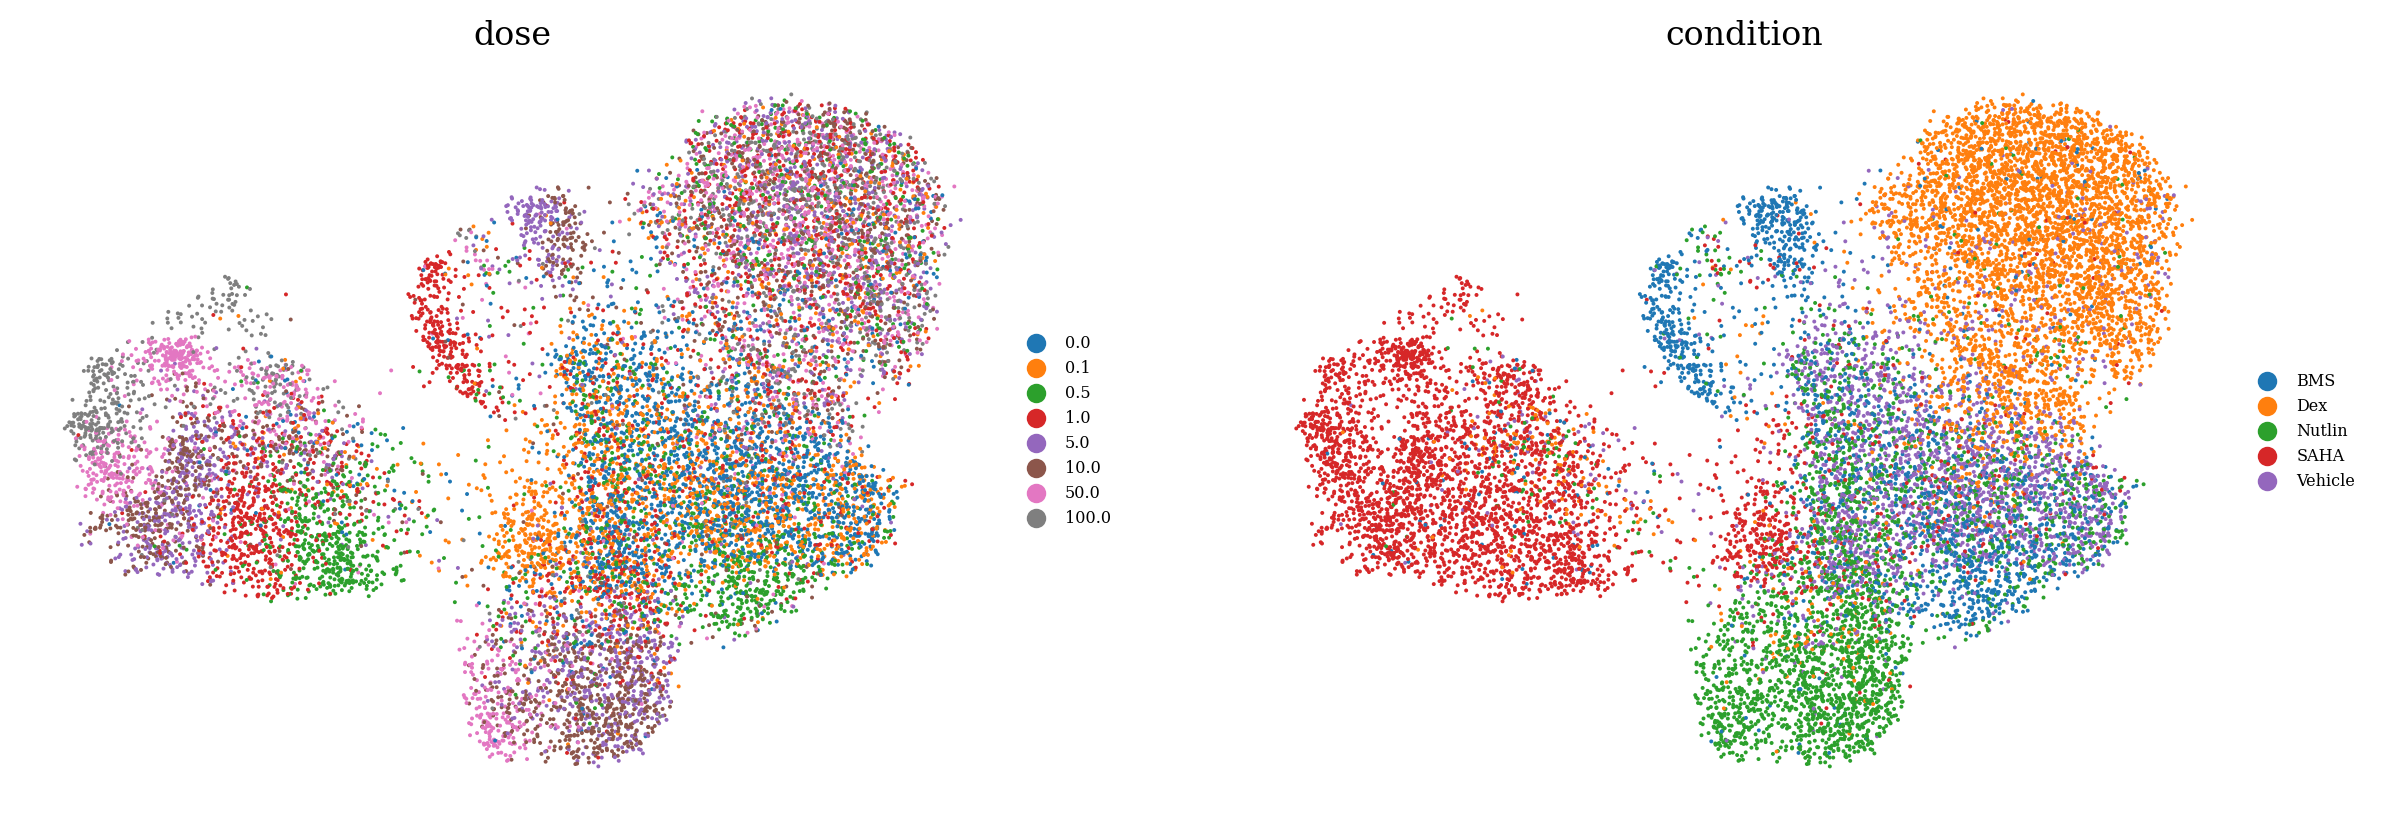

In [20]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

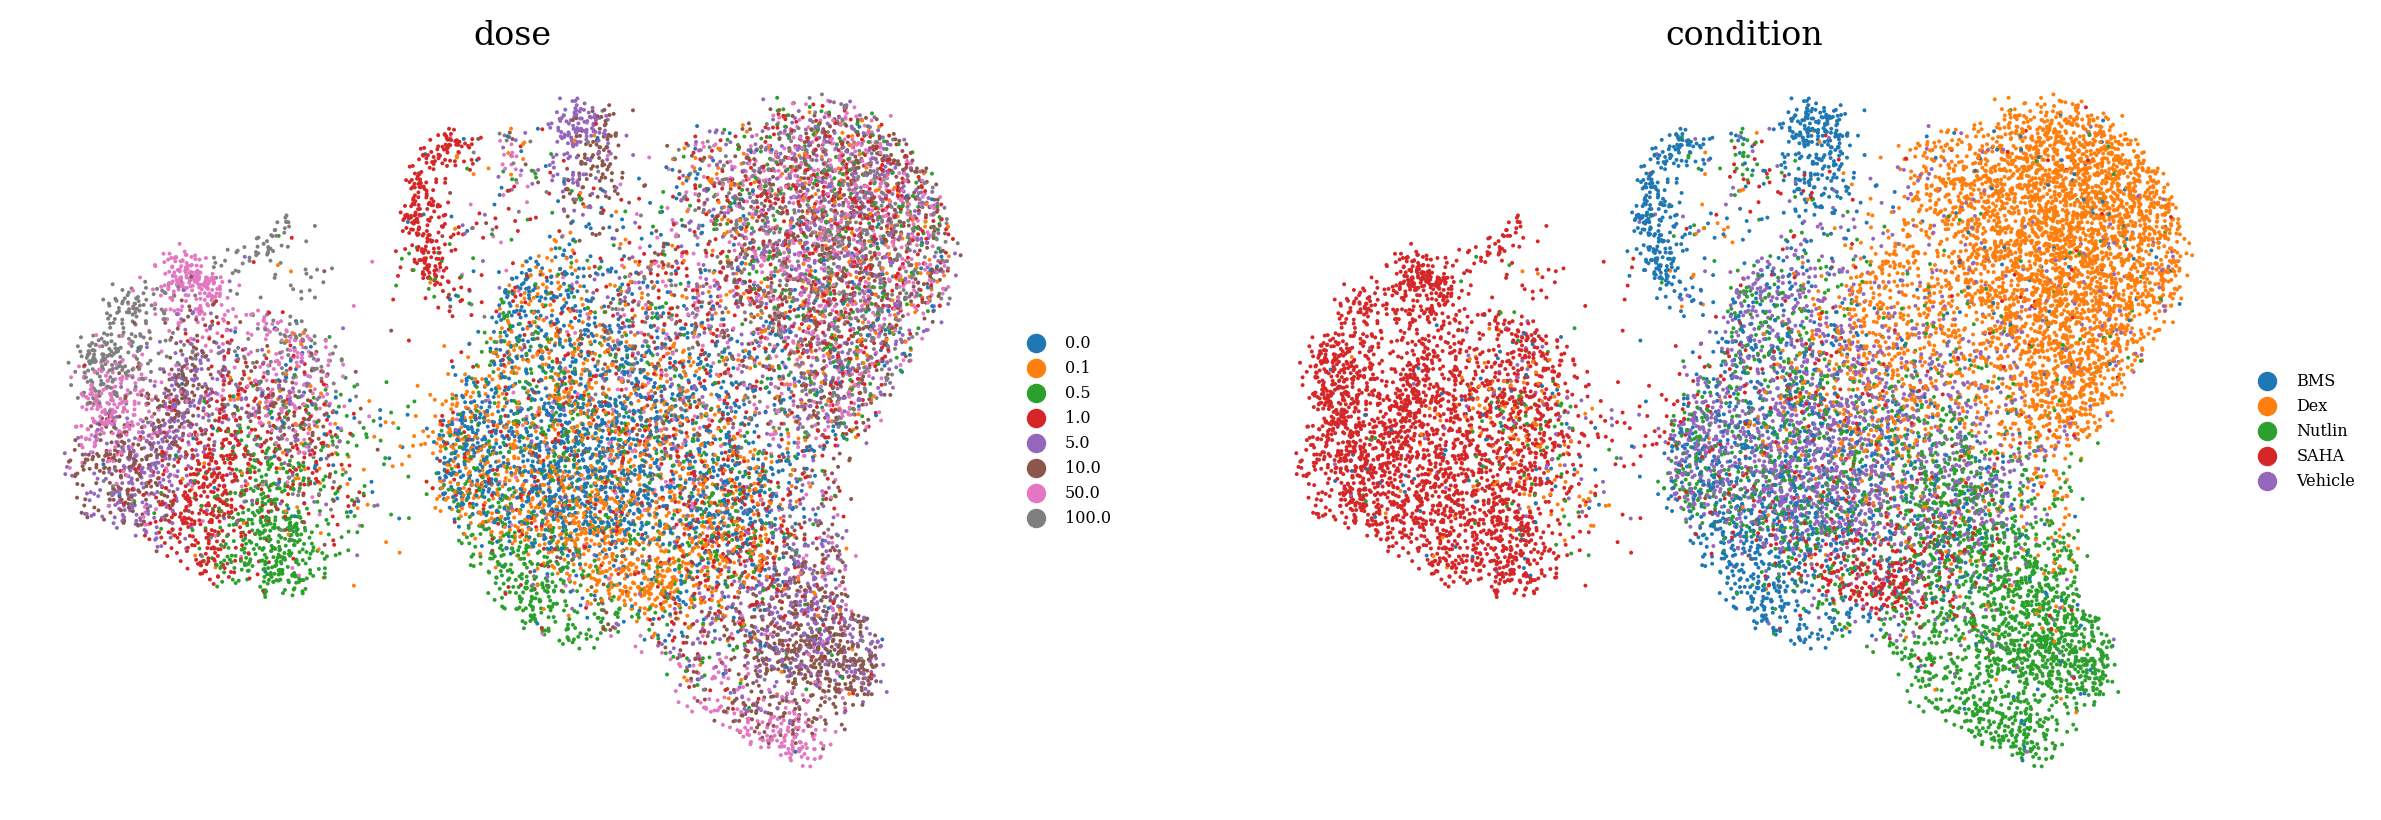

In [21]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [22]:
model.predict()

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 1/463 [00:00<02:13,  3.47it/s]

  5%|▍         | 23/463 [00:00<00:05, 74.34it/s]

 10%|▉         | 46/463 [00:00<00:03, 122.39it/s]

 15%|█▍        | 68/463 [00:00<00:02, 151.84it/s]

 19%|█▉        | 90/463 [00:00<00:02, 171.93it/s]

 24%|██▍       | 112/463 [00:00<00:01, 185.65it/s]

 29%|██▉       | 134/463 [00:00<00:01, 194.93it/s]

 34%|███▎      | 156/463 [00:01<00:01, 201.02it/s]

 38%|███▊      | 178/463 [00:01<00:01, 205.54it/s]

 43%|████▎     | 200/463 [00:01<00:01, 208.27it/s]

 48%|████▊     | 222/463 [00:01<00:01, 211.26it/s]

 53%|█████▎    | 244/463 [00:01<00:01, 212.90it/s]

 57%|█████▋    | 266/463 [00:01<00:00, 213.92it/s]

 62%|██████▏   | 289/463 [00:01<00:00, 217.02it/s]

 67%|██████▋   | 311/463 [00:01<00:00, 204.86it/s]

 72%|███████▏  | 333/463 [00:01<00:00, 207.47it/s]

 77%|███████▋  | 355/463 [00:01<00:00, 209.78it/s]

 81%|████████▏ | 377/463 [00:02<00:00, 175.69it/s]

 86%|████████▌ | 399/463 [00:02<00:00, 185.65it/s]

 91%|█████████ | 421/463 [00:02<00:00, 193.73it/s]

 96%|█████████▌| 443/463 [00:02<00:00, 200.00it/s]

100%|██████████| 463/463 [00:02<00:00, 184.10it/s]

In [23]:
pred_adata = adata[model.test_indices].copy()
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [24]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.989934484415628

In [25]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)